In [263]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from datetime import datetime
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from IPython.display import display, HTML
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 3)
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: unset; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')



In [264]:
#loading the dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df_trustpilot = pd.read_csv('data/data_trustpilot.csv', engine='python')

display(df_trustpilot.head())



,rating,location,username,verification,repeat_reviewer_encoded,company,subject,text,answer,answered,local_date_posted,month_posted,local_hour,time_of_day,day_of_week_posted,day_type,review_time
0,5,CA,Rob Crane,0,1,Flashbay,The company rep I worked with made my…,The company rep I worked with made my transaction smooth and quick. The samples were so helpful and the item shipping was relatively very fast. I will be a repeat customer.,0,0,2024-10-22,10,21,2,1,1,0
1,5,US,Pat Anderson,1,0,Flashbay,I highly recommend using Flashbay,I highly recommend using Flashbay. Immediately after ordering I heard from them and they were attentive to every little detail. I had notebooks shipped to Alaska for a conference and they arrived in perfect condition and delivered on time! Can't say enough good things about Flashbay!,0,0,2024-10-16,10,12,3,2,1,1
2,5,CZ,Margarita Orlova,1,0,Flashbay,Great customer service,"I had the pleasure of working with Shelby Gibson on a large order that we needed to ship to different locations. Shelby was very responsive, very kind and helpful. The order process was smooth and the final products look great. Only positive feedback from my side.",0,0,2024-10-17,10,10,3,3,1,0
3,5,US,Paola Rivas,1,0,Flashbay,Outstanding Support and Attentive Service,"I had a fantastic experience with Brian Truong. He was attentive, truly understood my needs, and provided all the support I needed. Excellent customer service—thank you!",0,0,2024-10-21,10,15,3,0,1,1
4,5,CA,Fiona Mckelvey Keenan,0,1,Flashbay,My number-one go-to for computer…,"My number-one go-to for computer accessories. Rachel was superb. She responded to my every request immediately, and her communication was satisfactory enough to get all the answers I wanted. Highly recommend!",0,0,2024-10-22,10,21,2,1,1,0


In [265]:
#First check
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])

print(df_trustpilot.columns)
display(df_trustpilot.info())

Index(['rating', 'location', 'username', 'verification',
       'repeat_reviewer_encoded', 'company', 'subject', 'text', 'answer',
       'answered', 'local_date_posted', 'month_posted', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type', 'review_time'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78404 entries, 0 to 78403
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   rating                   78404 non-null  int64         
 1   location                 78404 non-null  object        
 2   username                 78401 non-null  object        
 3   verification             78404 non-null  int64         
 4   repeat_reviewer_encoded  78404 non-null  int64         
 5   company                  78404 non-null  object        
 6   subject                  78404 non-null  object        
 7   text                     78404 non-null  o

None

STAGE 1 - UNIVARIATE ANALYSIS

In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def is_binary(df, column_name):
    return df[column_name].nunique() == 2

def analyze_statistics(df, column_name):
    print(f"Statistical analysis for column: {column_name}")
    print(f"{'='*50}")
    
    dtype = df[column_name].dtype

    if is_binary(df, column_name):
        print("\nBinary Variable Analysis:")
        value_counts = df[column_name].value_counts()
        percentages = df[column_name].value_counts(normalize=True) * 100
        print("\nDistribution:")
        for value, count in value_counts.items():
            pct = percentages[value]
            if column_name == 'repeat_reviewer_encoded':
                label = 'One-time reviewer' if value == 0 else 'Repeat reviewer'
            else:
                label = f"Value {value}"
            print(f"{label}: {count} ({pct:.1f}%)")
            
        print("\nConclusions:")
        majority_pct = max(percentages)
        majority_class = value_counts.index[0]
        if column_name == 'repeat_reviewer_encoded':
            majority_label = 'one-time reviewers' if majority_class == 0 else 'repeat reviewers'
            print(f"→ The dataset is {'highly ' if majority_pct > 75 else ''}dominated by {majority_label} ({majority_pct:.1f}%)")
            print(f"→ The class distribution is {'imbalanced' if abs(percentages[0] - percentages[1]) > 20 else 'relatively balanced'}")
    
    elif np.issubdtype(dtype, np.number):
        print("\nNumeric Variable Analysis:")
        print("\nBasic Statistics:")
        desc_stats = df[column_name].describe()
        print(desc_stats)
        mode_value = df[column_name].mode()[0]
        mode_count = df[column_name].value_counts().iloc[0]
        mean_value = df[column_name].mean()
        median_value = df[column_name].median()
        print("\nDetailed Statistics:")
        print(f"Most common value: {mode_value} (appears {mode_count} times)")
        print(f"Mean: {mean_value:.2f}")
        print(f"Median: {median_value:.2f}")
        skewness = df[column_name].skew()
        kurtosis = df[column_name].kurtosis()
        print("\nAdvanced Statistics with Interpretation:")
        print(f"Skewness: {skewness:.2f}")
        if abs(skewness) < 0.5:
            print("→ Distribution is fairly symmetric")
        elif abs(skewness) < 1:
            direction = "right" if skewness > 0 else "left"
            print(f"→ Distribution is moderately skewed to the {direction}")
        else:
            direction = "right" if skewness > 0 else "left"
            print(f"→ Distribution is highly skewed to the {direction}")
        print(f"\nKurtosis: {kurtosis:.2f}")
        if kurtosis < 3:
            print("→ Distribution has lighter tails than normal (platykurtic)")
        elif kurtosis > 3:
            print("→ Distribution has heavier tails than normal (leptokurtic)")
        else:
            print("→ Distribution has normal-like tails (mesokurtic)")
        
        z_scores = np.abs(stats.zscore(df[column_name]))
        outliers = len(z_scores[z_scores > 3])
        outliers_pct = (outliers/len(df[column_name])*100)
        print(f"\nOutlier Analysis:")
        print(f"Outliers (|z-score| > 3): {outliers}")
        print(f"Outlier percentage: {outliers_pct:.2f}%")
        
        print("\nOverall Conclusions:")
        if abs(mean_value - median_value) > 1:
            print(f"→ Large disparity between mean ({mean_value:.2f}) and median ({median_value:.2f}) "
                  f"indicates significant skew in the distribution")
        if mode_value == 1:
            print(f"→ Most common value is 1 ({mode_count} occurrences), "
                  f"indicating majority are one-time reviewers")
        if abs(skewness) > 10:
            print("→ Extremely non-normal distribution with severe right skew")
            print("→ This suggests a few users with very high review counts are pulling the average up")
        if outliers/len(df[column_name]) < 0.02:
            print(f"→ Limited outliers ({outliers_pct:.2f}%) suggest the extreme values, "
                  f"while present, are not dominating the distribution")
        
        print("\nRecommendations:")
        if abs(skewness) > 3 or kurtosis > 10:
            print("→ Consider analyzing one-time and repeat reviewers separately")
            print("→ Be cautious with mean-based metrics; median might be more representative")
        
    elif df[column_name].dtype == 'object':
        print("\nCategorical Variable Analysis:")
        if df[column_name].str.len().max() < 50:
            value_counts = df[column_name].value_counts()
            value_percentages = df[column_name].value_counts(normalize=True) * 100
            
            print("\nTop 10 Categories (Count and Percentage):")
            for val, count, pct in zip(value_counts.index[:10], 
                                     value_counts[:10], 
                                     value_percentages[:10]):
                print(f"{val}: {count} ({pct:.1f}%)")
                
    elif np.issubdtype(dtype, np.datetime64):
        print("\nDatetime Variable Analysis:")
        print("\nTemporal Range:")
        print(f"Earliest: {df[column_name].min()}")
        print(f"Latest: {df[column_name].max()}")
        print(f"Range: {df[column_name].max() - df[column_name].min()}")
        print(f"Total unique dates: {df[column_name].nunique()}")

def create_visualizations(df, column_name):
    print(f"Visualizations for column: {column_name}")
    print(f"{'='*50}")
    
    if is_binary(df, column_name):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        value_counts = df[column_name].value_counts()
        value_counts.plot(kind='bar', ax=ax1)
        ax1.set_title('Distribution of Classes')
        ax1.set_ylabel('Count')
        if column_name == 'repeat_reviewer_encoded':
            ax1.set_xticklabels(['One-time', 'Repeat'], rotation=0)
        plt.subplot(122)
        colors = ['#ff9999', '#66b3ff']
        value_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors)
        plt.title('Percentage Distribution')
        if column_name == 'repeat_reviewer_encoded':
            plt.legend(['One-time', 'Repeat'])
        plt.tight_layout()
        plt.show()
        
    else:
        dtype = df[column_name].dtype
        if np.issubdtype(dtype, np.number):
            fig = plt.figure(figsize=(20, 10))
            plt.subplot(231)
            sns.histplot(df[column_name], kde=True)
            plt.title('Distribution')
            plt.subplot(232)
            sns.boxplot(y=df[column_name])
            plt.title('Boxplot')
            plt.subplot(233)
            stats.probplot(df[column_name], dist="norm", plot=plt)
            plt.title('Q-Q Plot')
            if column_name == 'rating':
                plt.subplot(234)
                sns.boxplot(data=df, x='verification', y=column_name)
                plt.title('Rating by Verification Status')
                plt.xticks(rotation=45)
                plt.subplot(235)
                sns.boxplot(data=df, x='day_of_week_posted', y=column_name)
                plt.title('Rating by Day of Week')
                plt.xticks(rotation=45)
                plt.subplot(236)
                monthly_avg = df.groupby(df['local_date_posted'].dt.month)[column_name].mean()
                monthly_avg.plot(marker='o')
                plt.title('Average Rating by Month')
                plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            
        elif df[column_name].dtype == 'object':
            if df[column_name].str.len().max() < 50:
                fig = plt.figure(figsize=(20, 10))
                plt.subplot(231)
                df[column_name].value_counts().head(10).plot(kind='bar')
                plt.title('Top 10 Categories')
                plt.xticks(rotation=45)
                plt.subplot(232)
                plt.pie(df[column_name].value_counts(normalize=True).head(5) * 100,
                       labels=df[column_name].value_counts().head(5).index,
                       autopct='%1.1f%%')
                plt.title('Top 5 Categories Distribution')
                
        elif np.issubdtype(dtype, np.datetime64):
            fig = plt.figure(figsize=(20, 10))
            plt.subplot(231)
            df[column_name].dt.year.value_counts().sort_index().plot(kind='bar')
            plt.title('Year Distribution')
            plt.subplot(232)
            df[column_name].dt.month.value_counts().sort_index().plot(kind='bar')
            plt.title('Month Distribution')
            plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            plt.subplot(233)
            df[column_name].dt.dayofweek.value_counts().sort_index().plot(kind='bar')
            plt.title('Day of Week Distribution')
            plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
            
            if column_name in ['local_date_posted']:
                plt.subplot(234)
                df[column_name].dt.hour.value_counts().sort_index().plot(kind='bar')
                plt.title('Hour Distribution')
        
        plt.tight_layout()
        plt.show()

Statistical analysis for column: rating

Numeric Variable Analysis:

Basic Statistics:
count    78404.000
mean         3.521
std          1.698
min          1.000
25%          1.000
50%          4.000
75%          5.000
max          5.000
Name: rating, dtype: float64

Detailed Statistics:
Most common value: 5 (appears 38942 times)
Mean: 3.52
Median: 4.00

Advanced Statistics with Interpretation:
Skewness: -0.54
→ Distribution is moderately skewed to the left

Kurtosis: -1.45
→ Distribution has lighter tails than normal (platykurtic)

Outlier Analysis:
Outliers (|z-score| > 3): 0
Outlier percentage: 0.00%

Overall Conclusions:
→ Limited outliers (0.00%) suggest the extreme values, while present, are not dominating the distribution

Recommendations:
None
Visualizations for column: rating


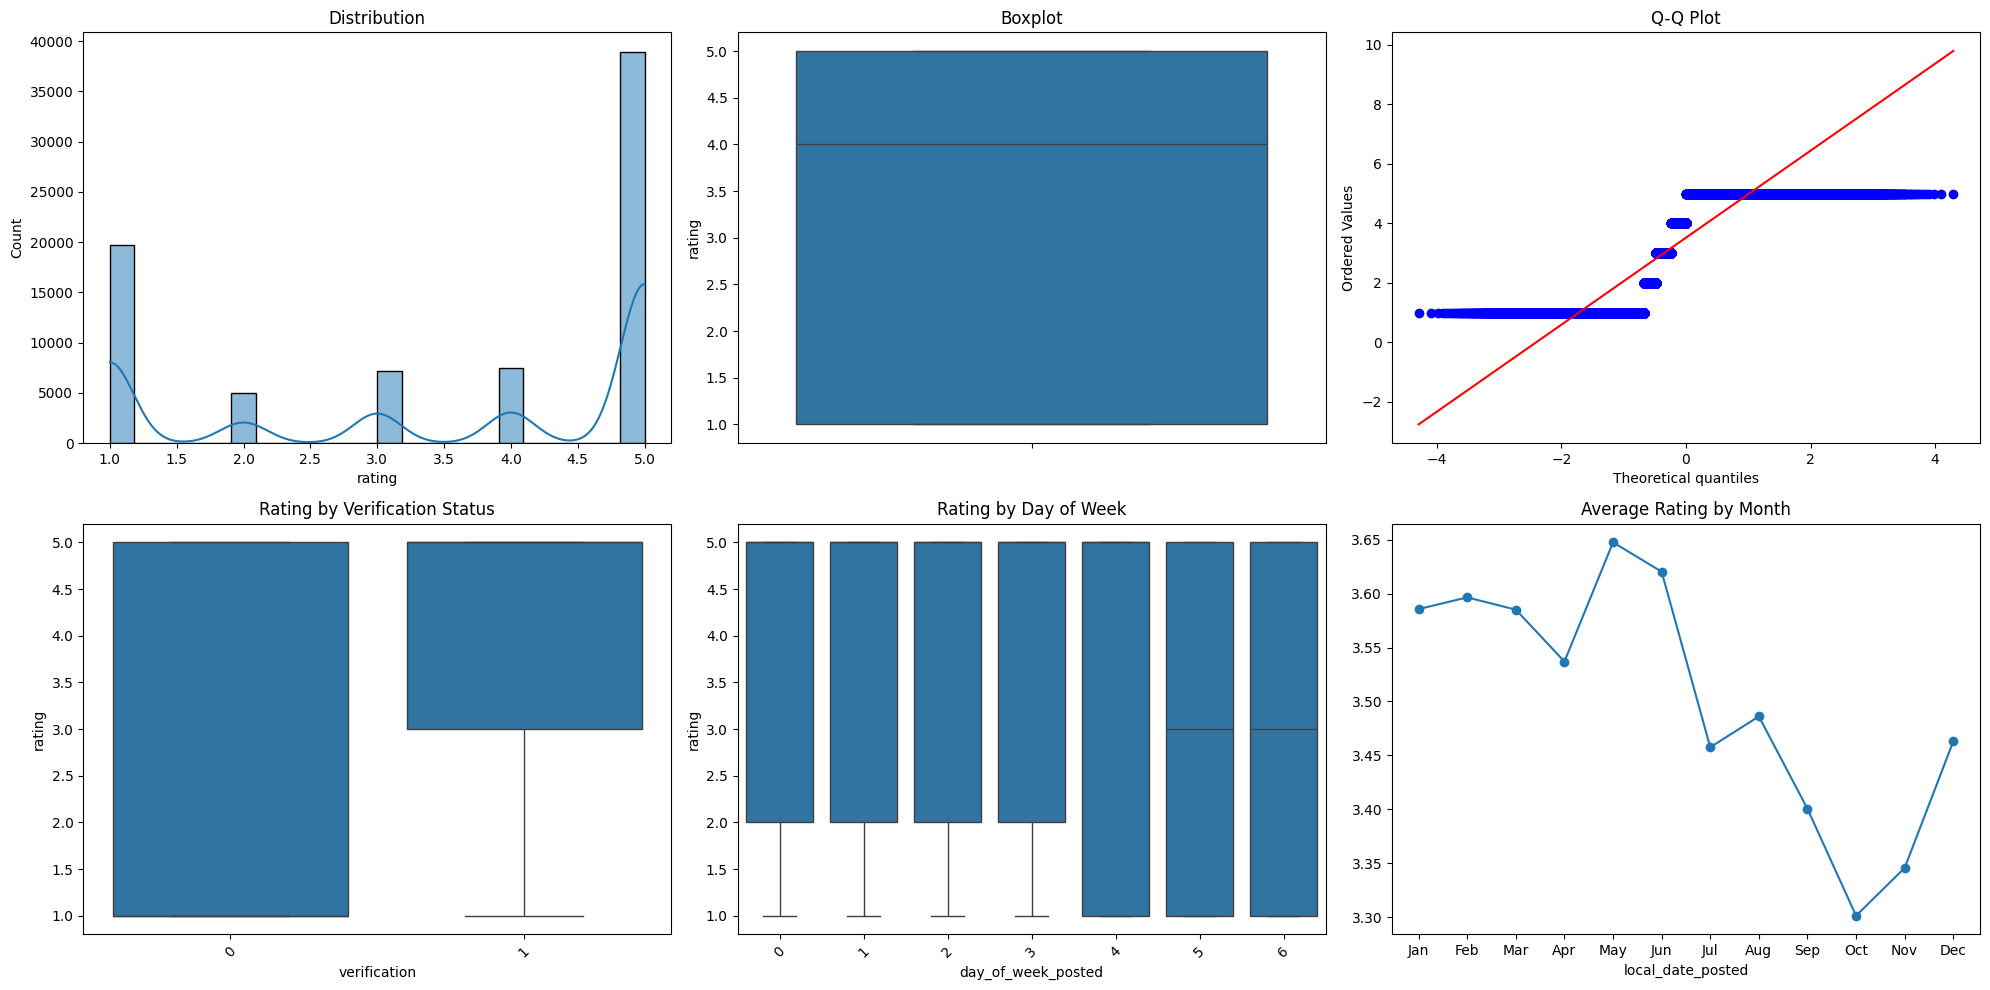

None


In [267]:
#Filtering out which columns not to consider because they are text-based
univariate_features = df_trustpilot.drop(['text', 'subject', 'answer', 'username'], axis=1)

print(analyze_statistics(df_trustpilot, univariate_features.columns[0]))
print(create_visualizations(df_trustpilot, univariate_features.columns[0]))

Statistical analysis for column: location

Categorical Variable Analysis:

Top 10 Categories (Count and Percentage):
US: 52431 (66.9%)
GB: 17377 (22.2%)
CA: 1703 (2.2%)
DE: 871 (1.1%)
FR: 491 (0.6%)
NL: 447 (0.6%)
AU: 381 (0.5%)
PL: 293 (0.4%)
SE: 271 (0.3%)
DK: 261 (0.3%)
None
Visualizations for column: location


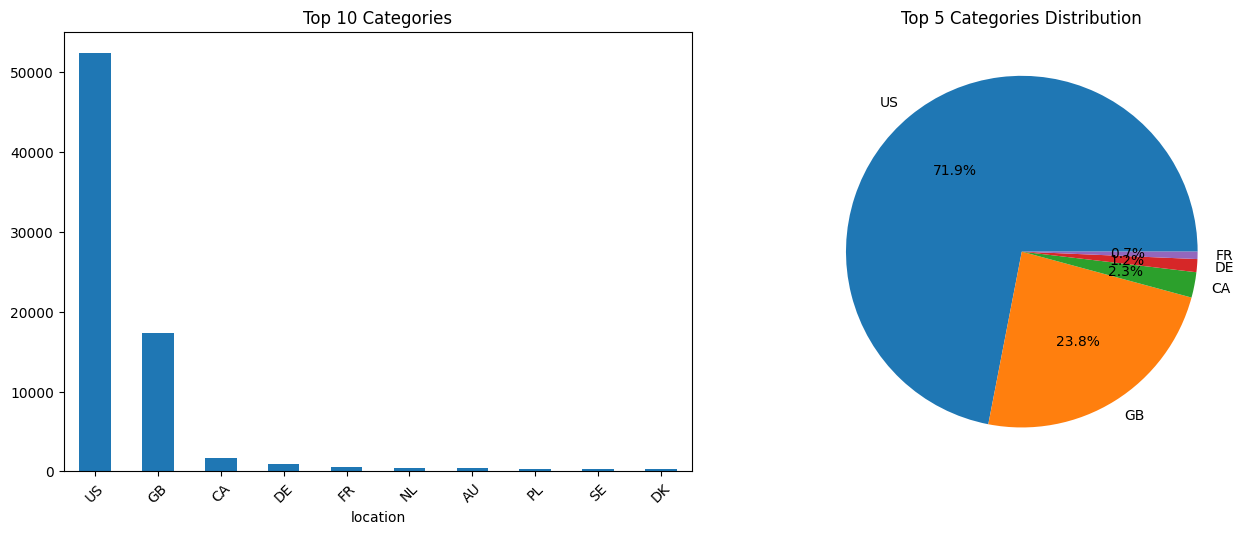

None


In [268]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[1]))
print(create_visualizations(df_trustpilot, univariate_features.columns[1]))

Statistical analysis for column: verification

Binary Variable Analysis:

Distribution:
Value 1: 50604 (64.5%)
Value 0: 27800 (35.5%)

Conclusions:
None
Visualizations for column: verification


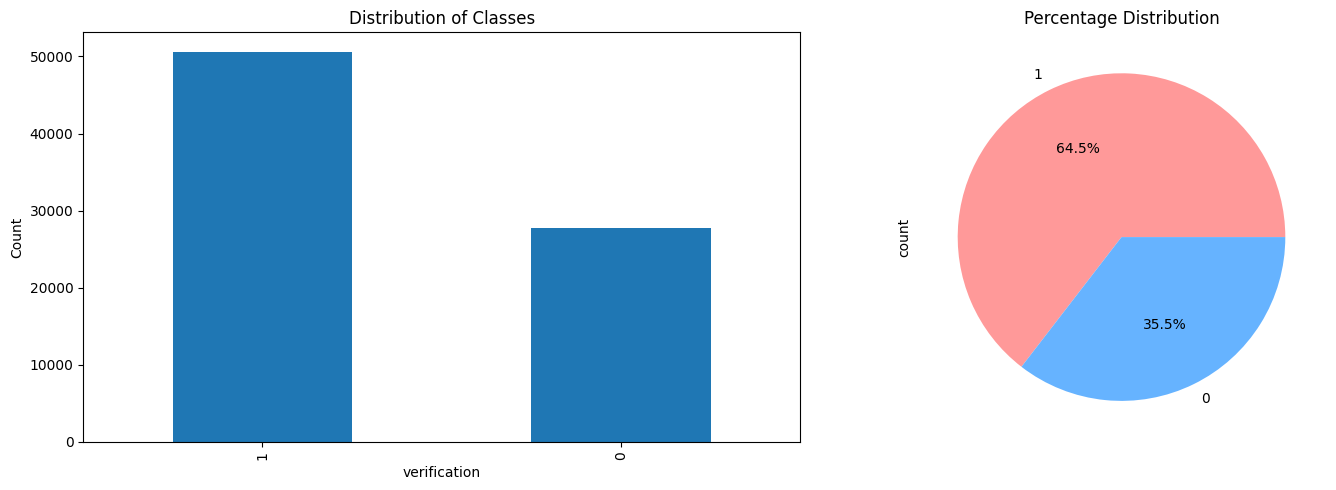

None


In [269]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[2]))
print(create_visualizations(df_trustpilot, univariate_features.columns[2]))

Statistical analysis for column: repeat_reviewer_encoded

Binary Variable Analysis:

Distribution:
One-time reviewer: 44009 (56.1%)
Repeat reviewer: 34395 (43.9%)

Conclusions:
→ The dataset is dominated by one-time reviewers (56.1%)
→ The class distribution is relatively balanced
None
Visualizations for column: repeat_reviewer_encoded


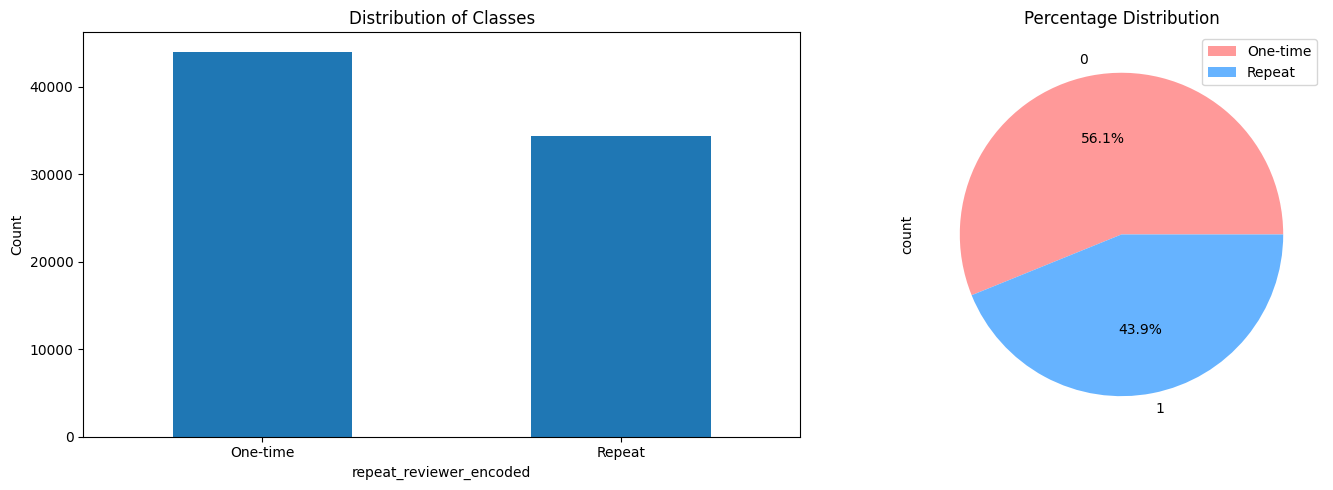

None


In [270]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[3]))
print(create_visualizations(df_trustpilot, univariate_features.columns[3]))

Statistical analysis for column: company

Categorical Variable Analysis:

Top 10 Categories (Count and Percentage):
Quicken: 29466 (37.6%)
Flashbay: 17675 (22.5%)
Asda: 15657 (20.0%)
SteelSeries: 15606 (19.9%)
None
Visualizations for column: company


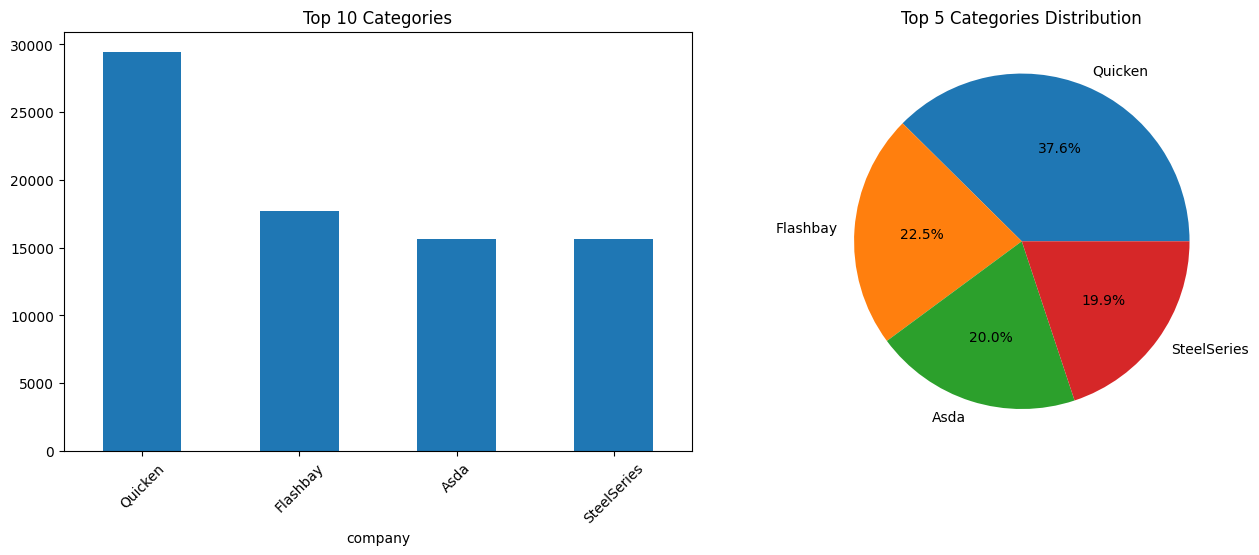

None


In [271]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[4]))
print(create_visualizations(df_trustpilot, univariate_features.columns[4]))

Statistical analysis for column: answered

Binary Variable Analysis:

Distribution:
Value 0: 58929 (75.2%)
Value 1: 19475 (24.8%)

Conclusions:
None
Visualizations for column: answered


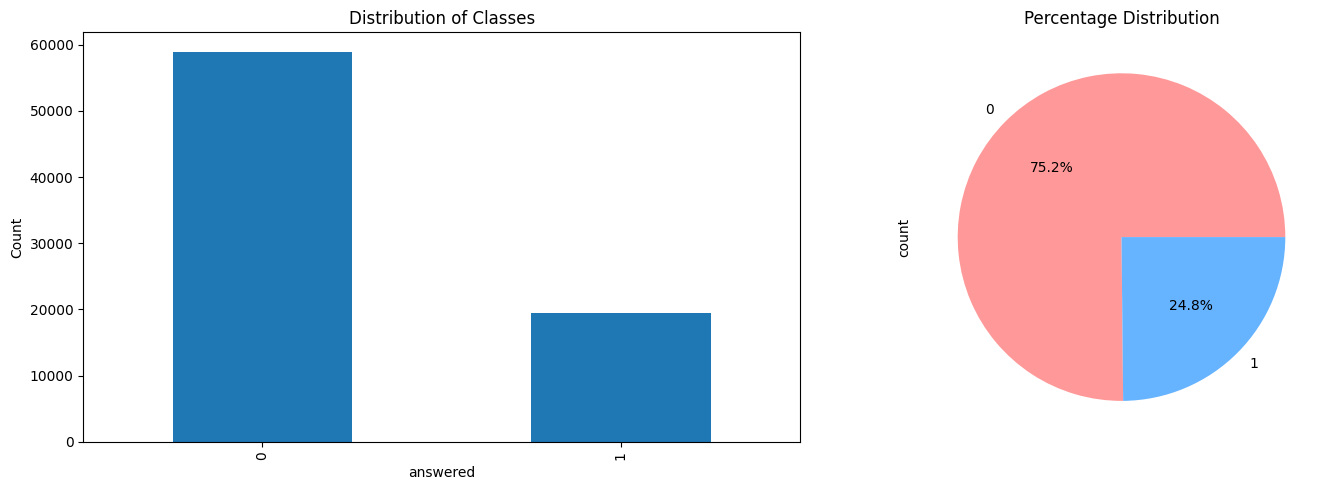

None


In [272]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[5]))
print(create_visualizations(df_trustpilot, univariate_features.columns[5]))

Statistical analysis for column: local_date_posted

Datetime Variable Analysis:

Temporal Range:
Earliest: 2009-06-09 00:00:00
Latest: 2024-10-23 00:00:00
Range: 5615 days 00:00:00
Total unique dates: 4654
None
Visualizations for column: local_date_posted


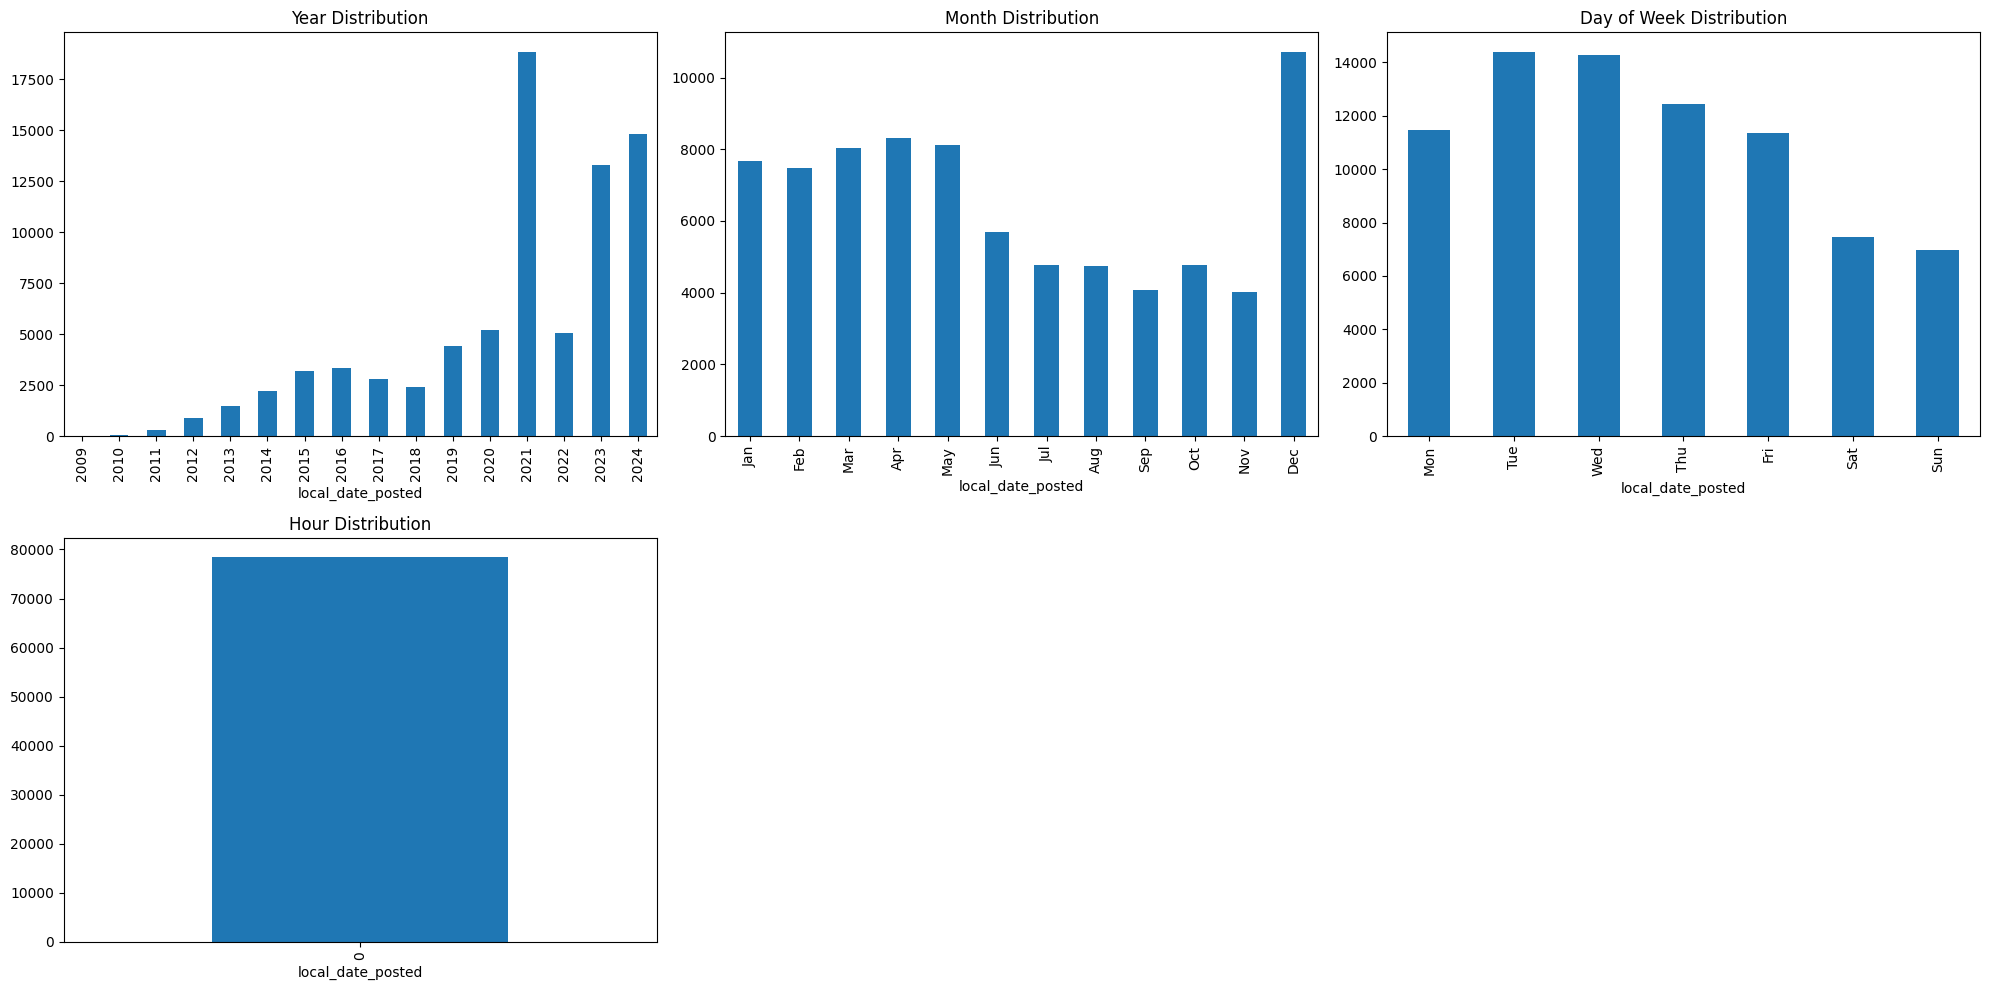

None


In [273]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[6]))
print(create_visualizations(df_trustpilot, univariate_features.columns[6]))

Statistical analysis for column: month_posted

Numeric Variable Analysis:

Basic Statistics:
count    78404.000
mean         6.162
std          3.653
min          1.000
25%          3.000
50%          5.000
75%          9.000
max         12.000
Name: month_posted, dtype: float64

Detailed Statistics:
Most common value: 12 (appears 10724 times)
Mean: 6.16
Median: 5.00

Advanced Statistics with Interpretation:
Skewness: 0.27
→ Distribution is fairly symmetric

Kurtosis: -1.23
→ Distribution has lighter tails than normal (platykurtic)

Outlier Analysis:
Outliers (|z-score| > 3): 0
Outlier percentage: 0.00%

Overall Conclusions:
→ Large disparity between mean (6.16) and median (5.00) indicates significant skew in the distribution
→ Limited outliers (0.00%) suggest the extreme values, while present, are not dominating the distribution

Recommendations:
None
Visualizations for column: month_posted


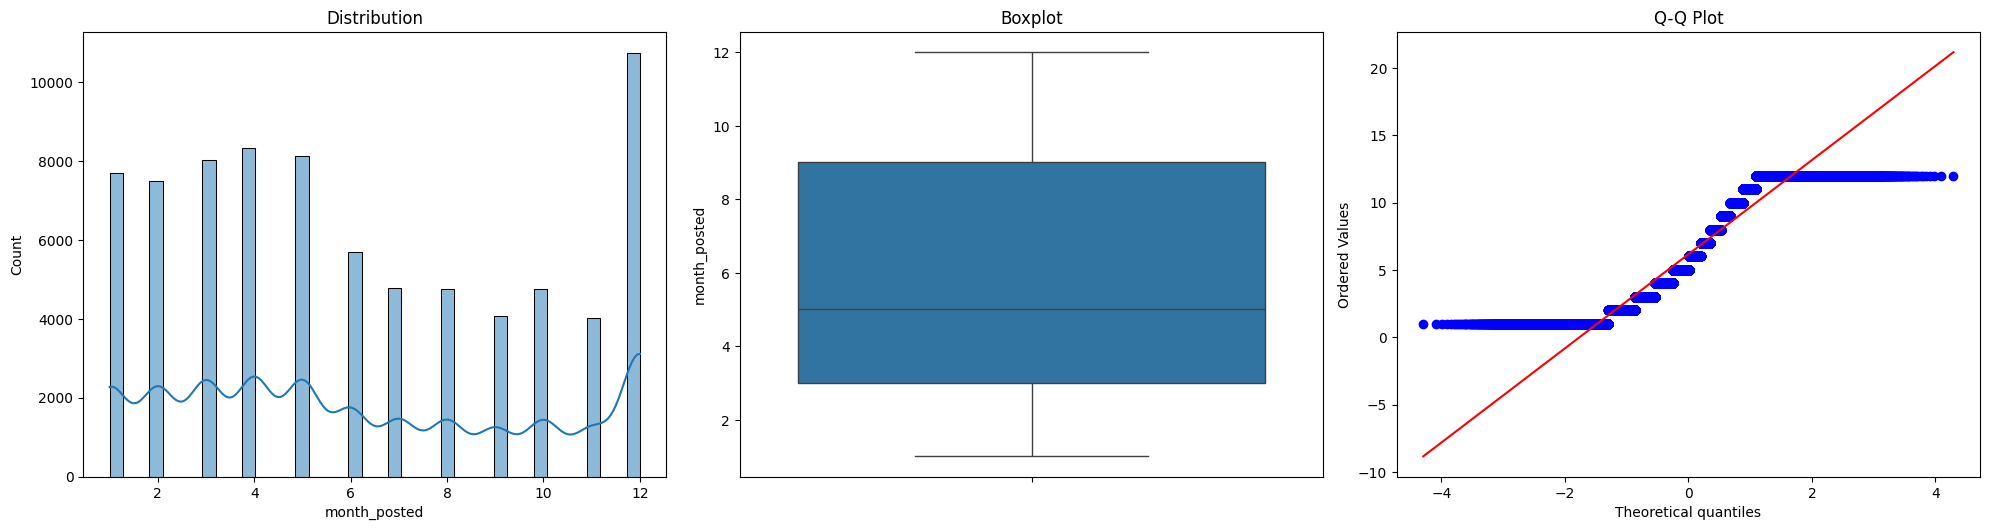

None


In [274]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[7]))
print(create_visualizations(df_trustpilot, univariate_features.columns[7]))

Statistical analysis for column: local_hour

Numeric Variable Analysis:

Basic Statistics:
count    78404.000
mean        12.381
std          4.898
min          0.000
25%          9.000
50%         12.000
75%         16.000
max         23.000
Name: local_hour, dtype: float64

Detailed Statistics:
Most common value: 9 (appears 6532 times)
Mean: 12.38
Median: 12.00

Advanced Statistics with Interpretation:
Skewness: 0.17
→ Distribution is fairly symmetric

Kurtosis: -0.57
→ Distribution has lighter tails than normal (platykurtic)

Outlier Analysis:
Outliers (|z-score| > 3): 0
Outlier percentage: 0.00%

Overall Conclusions:
→ Limited outliers (0.00%) suggest the extreme values, while present, are not dominating the distribution

Recommendations:
None
Visualizations for column: local_hour


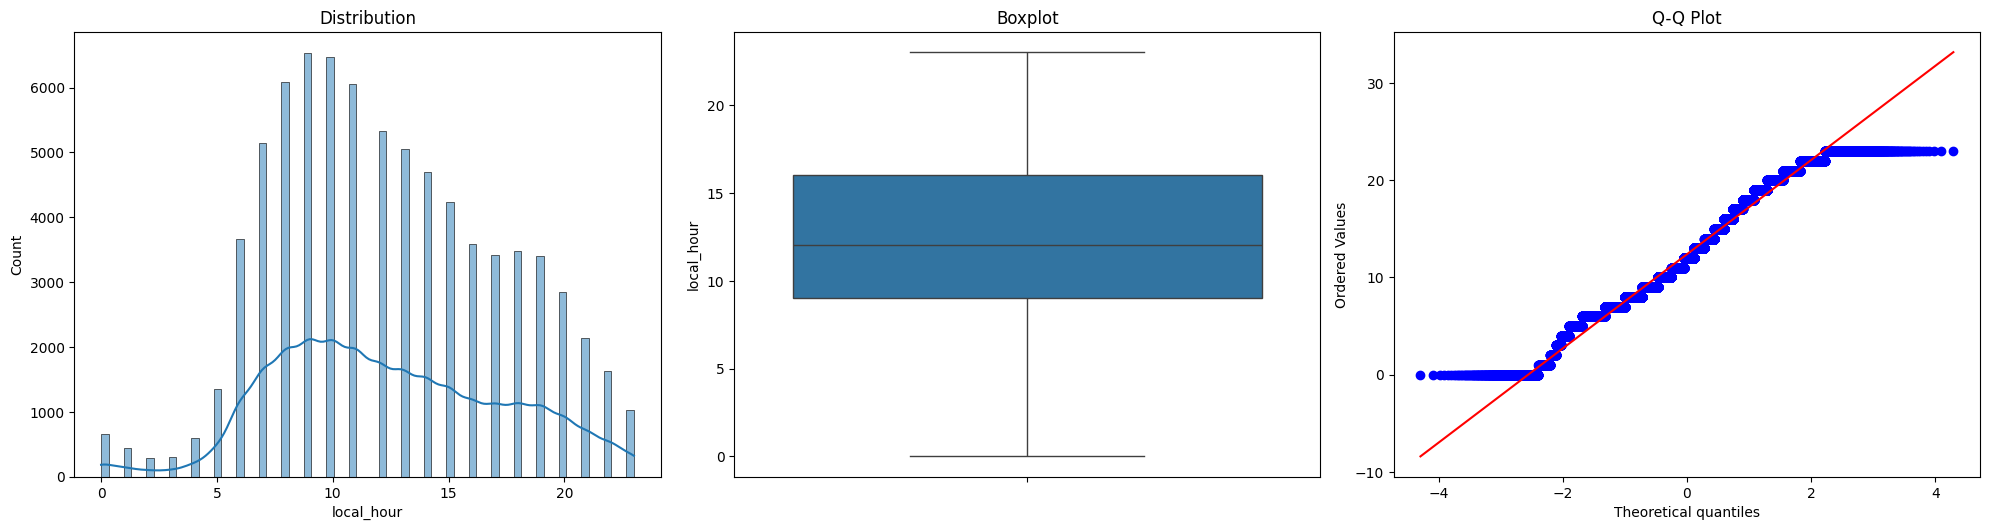

None


In [275]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[8]))
print(create_visualizations(df_trustpilot, univariate_features.columns[8]))

Statistical analysis for column: time_of_day

Numeric Variable Analysis:

Basic Statistics:
count    78404.000
mean         2.270
std          0.966
min          0.000
25%          2.000
50%          3.000
75%          3.000
max          3.000
Name: time_of_day, dtype: float64

Detailed Statistics:
Most common value: 3 (appears 45370 times)
Mean: 2.27
Median: 3.00

Advanced Statistics with Interpretation:
Skewness: -0.96
→ Distribution is moderately skewed to the left

Kurtosis: -0.43
→ Distribution has lighter tails than normal (platykurtic)

Outlier Analysis:
Outliers (|z-score| > 3): 0
Outlier percentage: 0.00%

Overall Conclusions:
→ Limited outliers (0.00%) suggest the extreme values, while present, are not dominating the distribution

Recommendations:
None
Visualizations for column: time_of_day


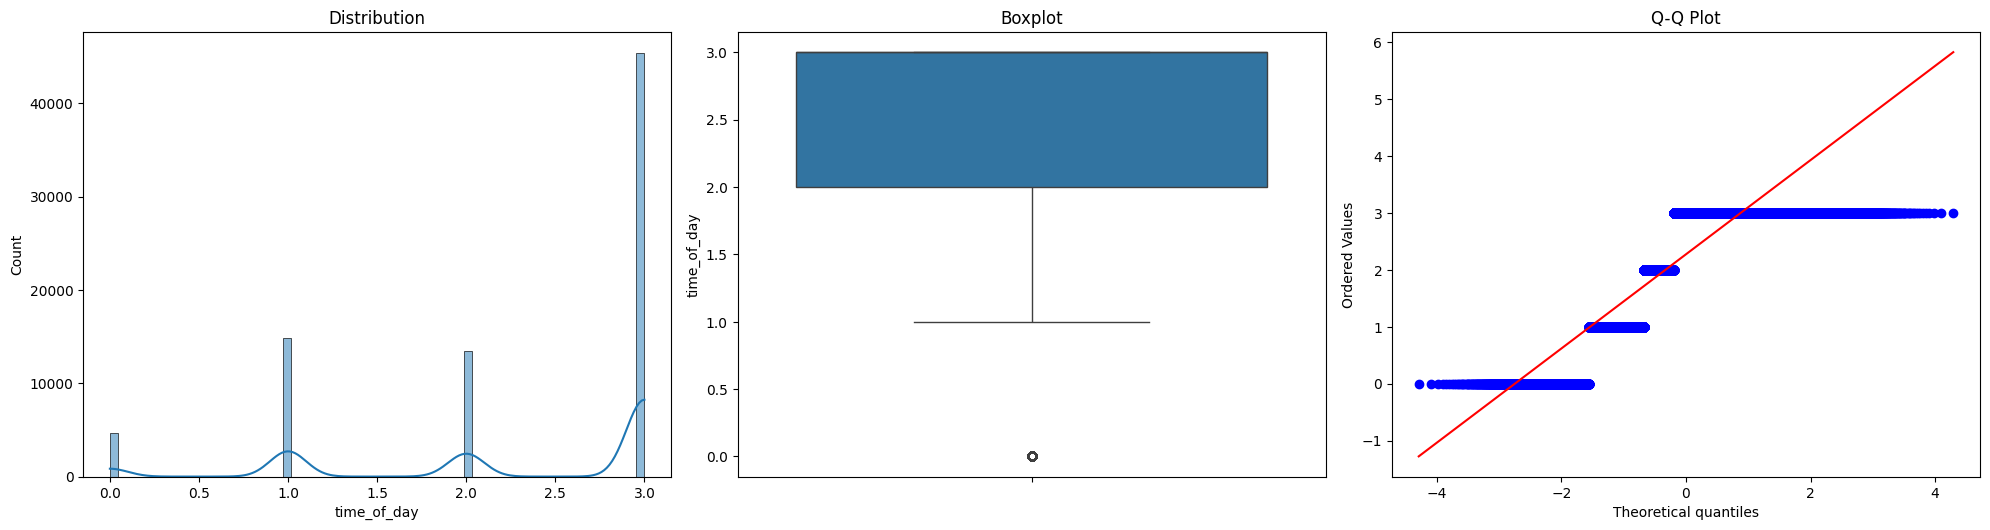

None


In [276]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[9]))
print(create_visualizations(df_trustpilot, univariate_features.columns[9]))

Statistical analysis for column: day_of_week_posted

Numeric Variable Analysis:

Basic Statistics:
count    78404.000
mean         2.614
std          1.847
min          0.000
25%          1.000
50%          2.000
75%          4.000
max          6.000
Name: day_of_week_posted, dtype: float64

Detailed Statistics:
Most common value: 1 (appears 14406 times)
Mean: 2.61
Median: 2.00

Advanced Statistics with Interpretation:
Skewness: 0.27
→ Distribution is fairly symmetric

Kurtosis: -0.99
→ Distribution has lighter tails than normal (platykurtic)

Outlier Analysis:
Outliers (|z-score| > 3): 0
Outlier percentage: 0.00%

Overall Conclusions:
→ Most common value is 1 (14406 occurrences), indicating majority are one-time reviewers
→ Limited outliers (0.00%) suggest the extreme values, while present, are not dominating the distribution

Recommendations:
None
Visualizations for column: day_of_week_posted


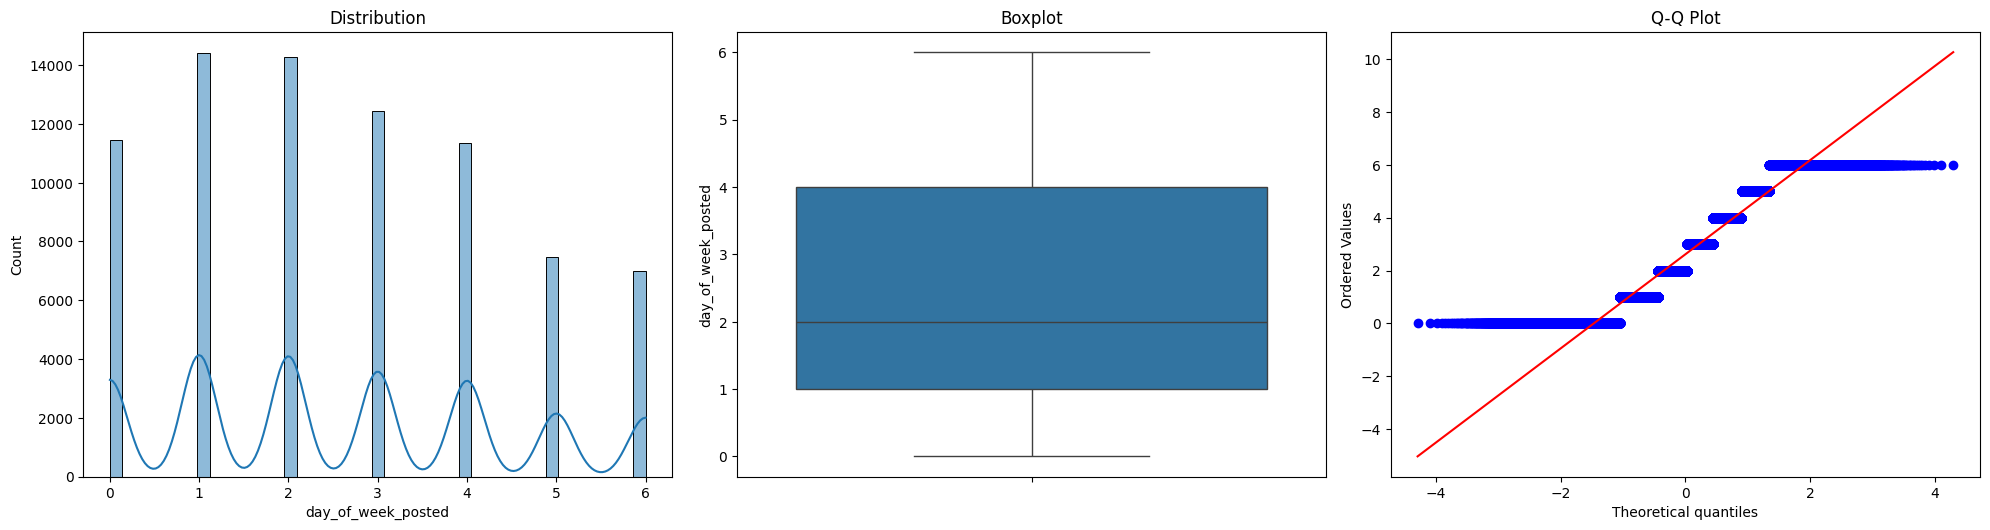

None


In [277]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[10]))
print(create_visualizations(df_trustpilot, univariate_features.columns[10]))

Statistical analysis for column: day_type

Binary Variable Analysis:

Distribution:
Value 1: 63952 (81.6%)
Value 0: 14452 (18.4%)

Conclusions:
None
Visualizations for column: day_type


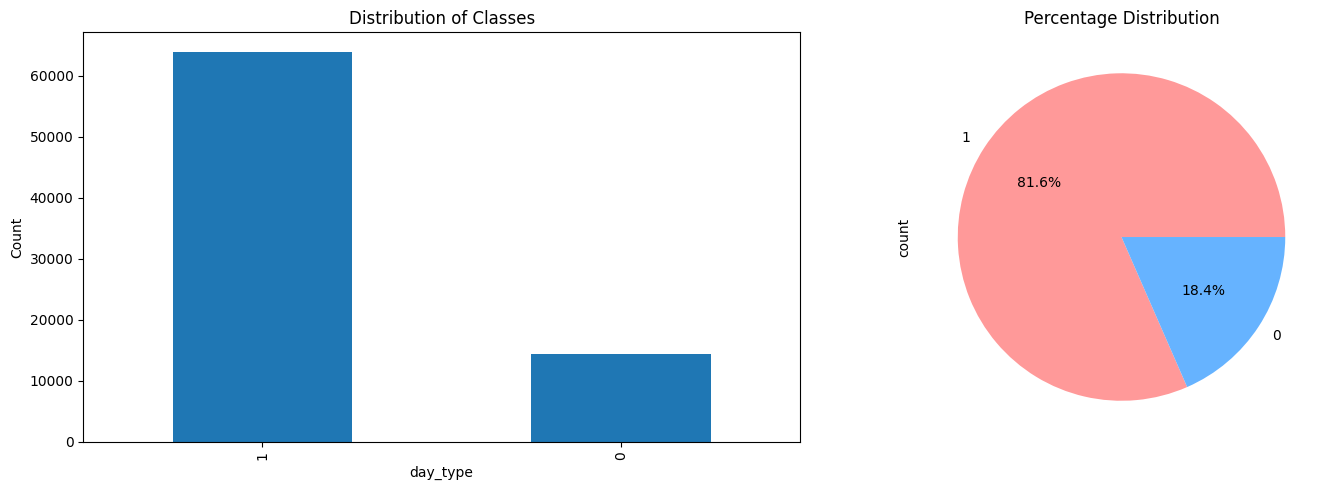

None


In [278]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[11]))
print(create_visualizations(df_trustpilot, univariate_features.columns[11]))

Statistical analysis for column: review_time

Binary Variable Analysis:

Distribution:
Value 1: 62864 (80.2%)
Value 0: 15540 (19.8%)

Conclusions:
None
Visualizations for column: review_time


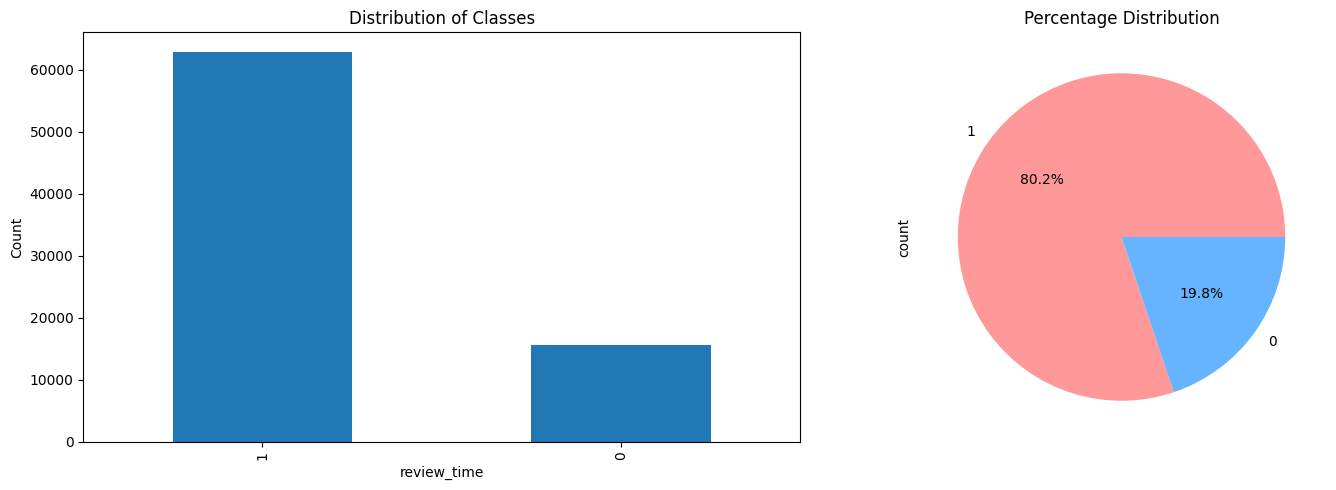

None


In [279]:
print(analyze_statistics(df_trustpilot, univariate_features.columns[12]))
print(create_visualizations(df_trustpilot, univariate_features.columns[12]))

STAGE 2 - MULTIVARIATE ANALYSIS

In [280]:
def is_binary(df, column_name):
    """Check if a column is binary (has exactly 2 unique values)"""
    return df[column_name].nunique() == 2

def analyze_multivariate(df, column_name, target='rating'):
    """
    Core multivariate analysis focusing on relationship between specified column and target.
    """
    print(f"\nMULTIVARIATE ANALYSIS FOR {column_name}")
    print("="*80)
    
    # Skip text-heavy columns
    if column_name in ['subject', 'text', 'answer']:
        print("Skipping text analysis column")
        return
    
    # Get column type
    dtype = df[column_name].dtype
    
    # BINARY VARIABLE ANALYSIS
    if is_binary(df, column_name):
        print("\nBinary Variable Analysis:")
        
        # Get unique values and ensure they're sorted
        values = sorted(df[column_name].unique())
        
        # Create figure with violin and bar plots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
        
        # Violin plot to show full distribution
        sns.violinplot(data=df, x=column_name, y=target, ax=ax1)
        if column_name == 'repeat_reviewer_encoded':
            ax1.set_xticklabels(['One-time', 'Repeat'])
        ax1.set_title(f'Distribution of {target} by {column_name}')
        
        # Bar plot of means
        sns.barplot(data=df, x=column_name, y=target, ax=ax2)
        if column_name == 'repeat_reviewer_encoded':
            ax2.set_xticklabels(['One-time', 'Repeat'])
        ax2.set_title(f'Mean {target} by {column_name}')
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print("\nSummary Statistics by Group:")
        summary = df.groupby(column_name)[target].agg([
            'count', 'mean', 'median', 'std'
        ]).round(2)
        
        # Rename index for repeat_reviewer_encoded
        if column_name == 'repeat_reviewer_encoded':
            summary.index = ['One-time', 'Repeat']
        print(summary)
        
        # Calculate difference between groups using values list
        group_means = df.groupby(column_name)[target].mean()
        diff = group_means.iloc[1] - group_means.iloc[0]
        print(f"\nDifference in means (1 - 0): {diff:.2f}")
        
        # Distribution comparison
        print("\nDistribution of ratings by group:")
        rating_dist = pd.crosstab(df[column_name], df[target], normalize='index') * 100
        if column_name == 'repeat_reviewer_encoded':
            rating_dist.index = ['One-time', 'Repeat']
        print(rating_dist.round(2))
    
    # NUMERIC VARIABLE ANALYSIS (non-binary)
    elif np.issubdtype(dtype, np.number) and column_name != target:
        # Scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x=column_name, y=target, alpha=0.5)
        plt.title(f'{target} vs {column_name}')
        plt.show()
        
        # Group statistics
        print("\nGrouped Statistics:")
        try:
            group_stats = df.groupby(pd.qcut(df[column_name], q=5, duplicates='drop'))[target].agg([
                'count', 'mean', 'median', 'std'
            ]).round(2)
            group_stats.index = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
            print(group_stats)
        except ValueError:
            # For columns with too many duplicate values, use unique values instead
            unique_values = sorted(df[column_name].unique())
            group_stats = df.groupby(column_name)[target].agg([
                'count', 'mean', 'median', 'std'
            ]).round(2)
            print(group_stats)
    
    # CATEGORICAL VARIABLE ANALYSIS (including datetime)
    elif dtype == 'object' or np.issubdtype(dtype, np.datetime64):
        # Special handling for month_posted
        if column_name == 'month_posted':
            # Create month name mapping
            month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 
                        5: 'May', 6: 'June', 7: 'July', 8: 'August',
                        9: 'September', 10: 'October', 11: 'November', 12: 'December'}
            
            # Create figure
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
            
            # Box plot
            sns.boxplot(data=df, x='month_posted', y=target, order=range(1,13), ax=ax1)
            ax1.set_xticklabels([month_map[i] for i in range(1,13)], rotation=45)
            ax1.set_title(f'Distribution of {target} by Month')
            
            # Bar plot of means
            monthly_stats = df.groupby('month_posted')[target].agg(['mean', 'std', 'count'])
            monthly_stats = monthly_stats.reindex(range(1,13))  # ensure all months are included in order
            
            sns.barplot(data=df, x='month_posted', y=target, ci='sd', 
                       order=range(1,13), ax=ax2)
            ax2.set_xticklabels([month_map[i] for i in range(1,13)], rotation=45)
            ax2.set_title(f'Mean {target} by Month (with standard deviation)')
            
            plt.tight_layout()
            plt.show()
            
            # Summary statistics
            print("\nMonthly Statistics:")
            monthly_stats.index = [month_map[i] for i in range(1,13)]
            print(monthly_stats.round(2))
            
        else:
            # Get top 10 categories by frequency
            top_categories = df[column_name].value_counts().head(10).index
            df_filtered = df[df[column_name].isin(top_categories)]
            
            # Visualizations
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
            
            # Box plot
            sns.boxplot(data=df_filtered, x=column_name, y=target, ax=ax1)
            ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
            ax1.set_title(f'Distribution of {target} by {column_name}')
            
            # Bar plot of means with error bars
            summary = df_filtered.groupby(column_name)[target].agg(['mean', 'std', 'count'])
            summary['se'] = summary['std'] / np.sqrt(summary['count'])
            
            sns.barplot(data=df_filtered, x=column_name, y=target, ci='sd', ax=ax2)
            ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
            ax2.set_title(f'Mean {target} by {column_name} (with standard deviation)')
            
            plt.tight_layout()
            plt.show()
            
            # Summary statistics
            print("\nSummary Statistics for Top 10 Categories:")
            print(summary.round(2))
            
            # Specific company analysis
            if column_name == 'company':
                print("\nDetailed Company Analysis:")
                for company in top_categories:
                    company_data = df[df['company'] == company]
                    print(f"\n{company}:")
                    print(f"Total reviews: {len(company_data):,}")
                    print(f"Average rating: {company_data[target].mean():.2f}")
                    if 'local_date_posted' in df.columns:
                        # Overall trend (first year vs last year)
                        trend = (company_data.groupby(company_data['local_date_posted'].dt.year)[target].mean().iloc[-1] - 
                                company_data.groupby(company_data['local_date_posted'].dt.year)[target].mean().iloc[0])
                        print(f"Rating trend (start to end): {trend:.2f}")
                        # Recent average
                        recent_avg = company_data.tail(90)[target].mean()
                        print(f"Most recent average (last 3 months): {recent_avg:.2f}")



MULTIVARIATE ANALYSIS FOR location


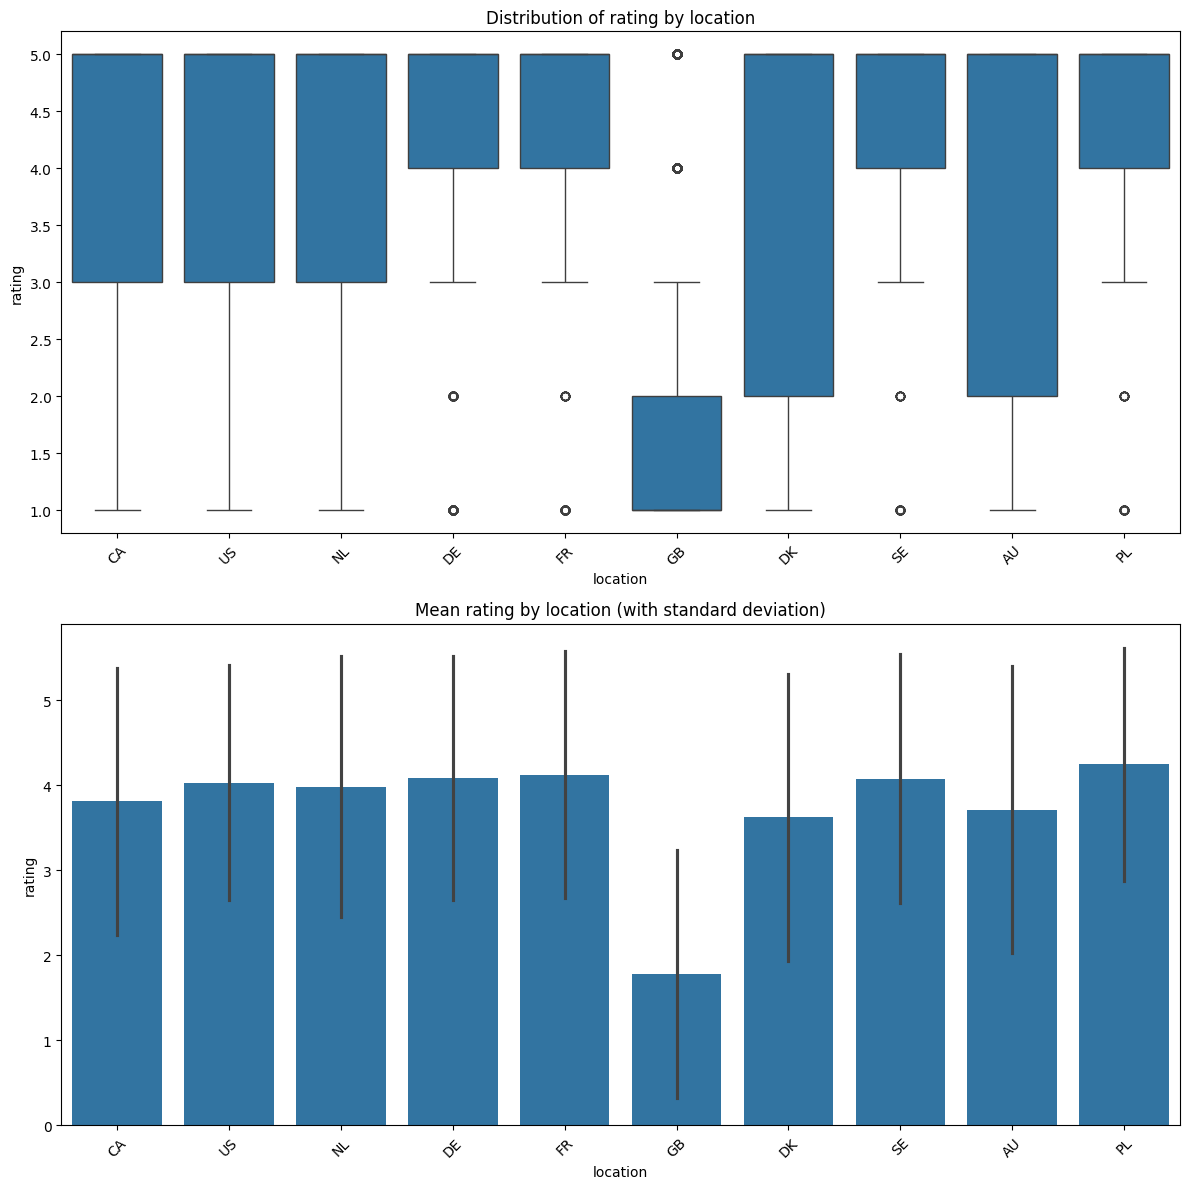


Summary Statistics for Top 10 Categories:
          mean   std  count    se
location                         
AU        3.71  1.69    381  0.09
CA        3.81  1.57   1703  0.04
DE        4.09  1.44    871  0.05
DK        3.62  1.69    261  0.10
FR        4.12  1.45    491  0.07
GB        1.78  1.46  17377  0.01
NL        3.98  1.53    447  0.07
PL        4.25  1.37    293  0.08
SE        4.08  1.47    271  0.09
US        4.03  1.39  52431  0.01
None


In [281]:
univariate_features = df_trustpilot.drop(['rating', 'username', 'month_posted', 'local_hour', 'time_of_day', 'day_of_week_posted'], axis=1)

print(analyze_multivariate(df_trustpilot, univariate_features.columns[0], target='rating'))


MULTIVARIATE ANALYSIS FOR verification

Binary Variable Analysis:


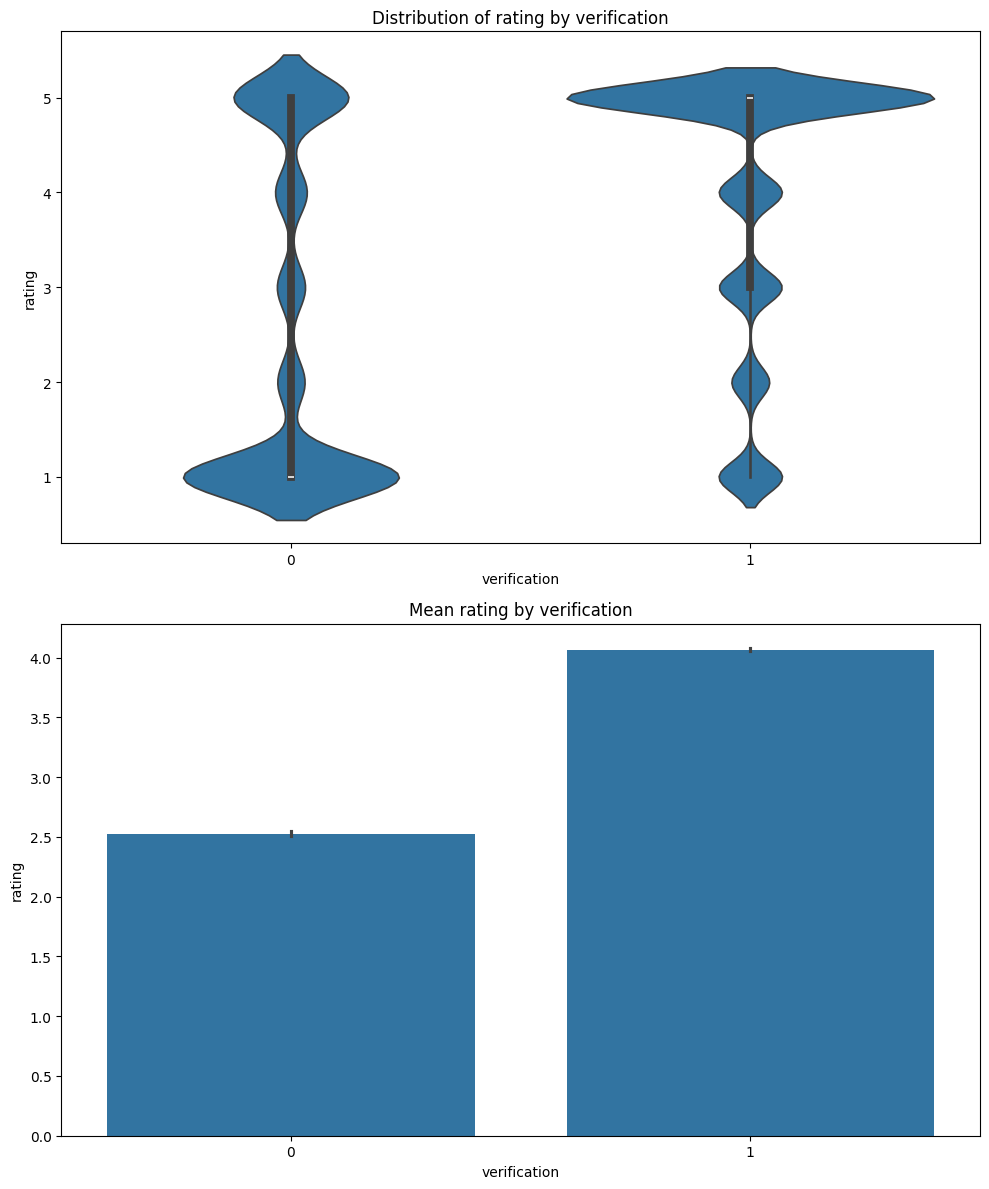


Summary Statistics by Group:
              count  mean  median   std
verification                           
0             27800  2.53     1.0  1.76
1             50604  4.07     5.0  1.39

Difference in means (1 - 0): 1.54

Distribution of ratings by group:
rating            1     2      3      4      5
verification                                  
0             51.65  6.53   6.74   7.58  27.50
1             10.66  6.35  10.54  10.60  61.84
None


In [282]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[1], target='rating'))


MULTIVARIATE ANALYSIS FOR repeat_reviewer_encoded

Binary Variable Analysis:


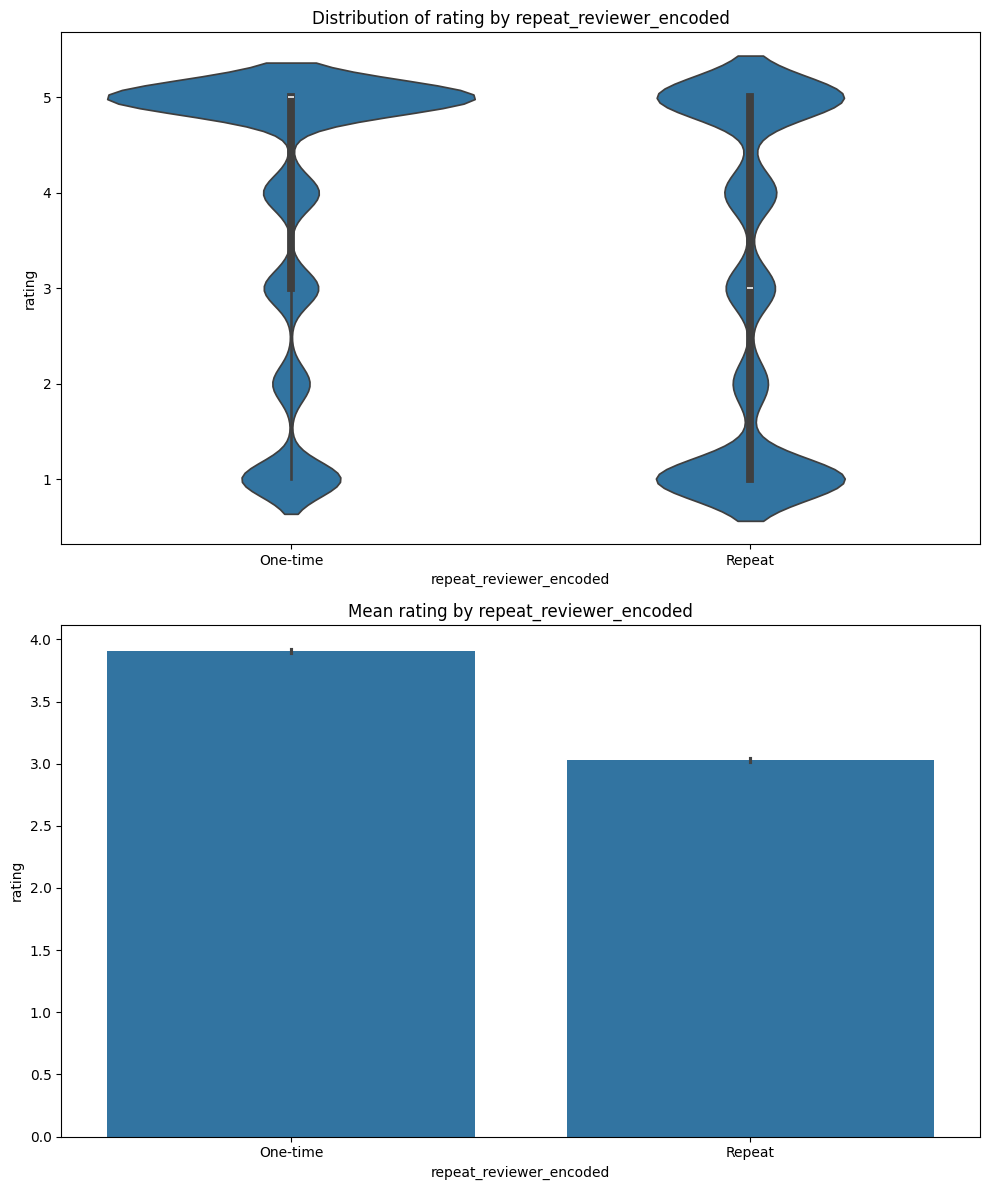


Summary Statistics by Group:
          count  mean  median   std
One-time  44009  3.91     5.0  1.54
Repeat    34395  3.03     3.0  1.76

Difference in means (1 - 0): -0.88

Distribution of ratings by group:
rating        1     2     3      4      5
One-time  16.09  6.06  8.86   9.06  59.93
Repeat    36.84  6.87  9.62  10.13  36.54
None


In [283]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[2], target='rating'))


MULTIVARIATE ANALYSIS FOR company


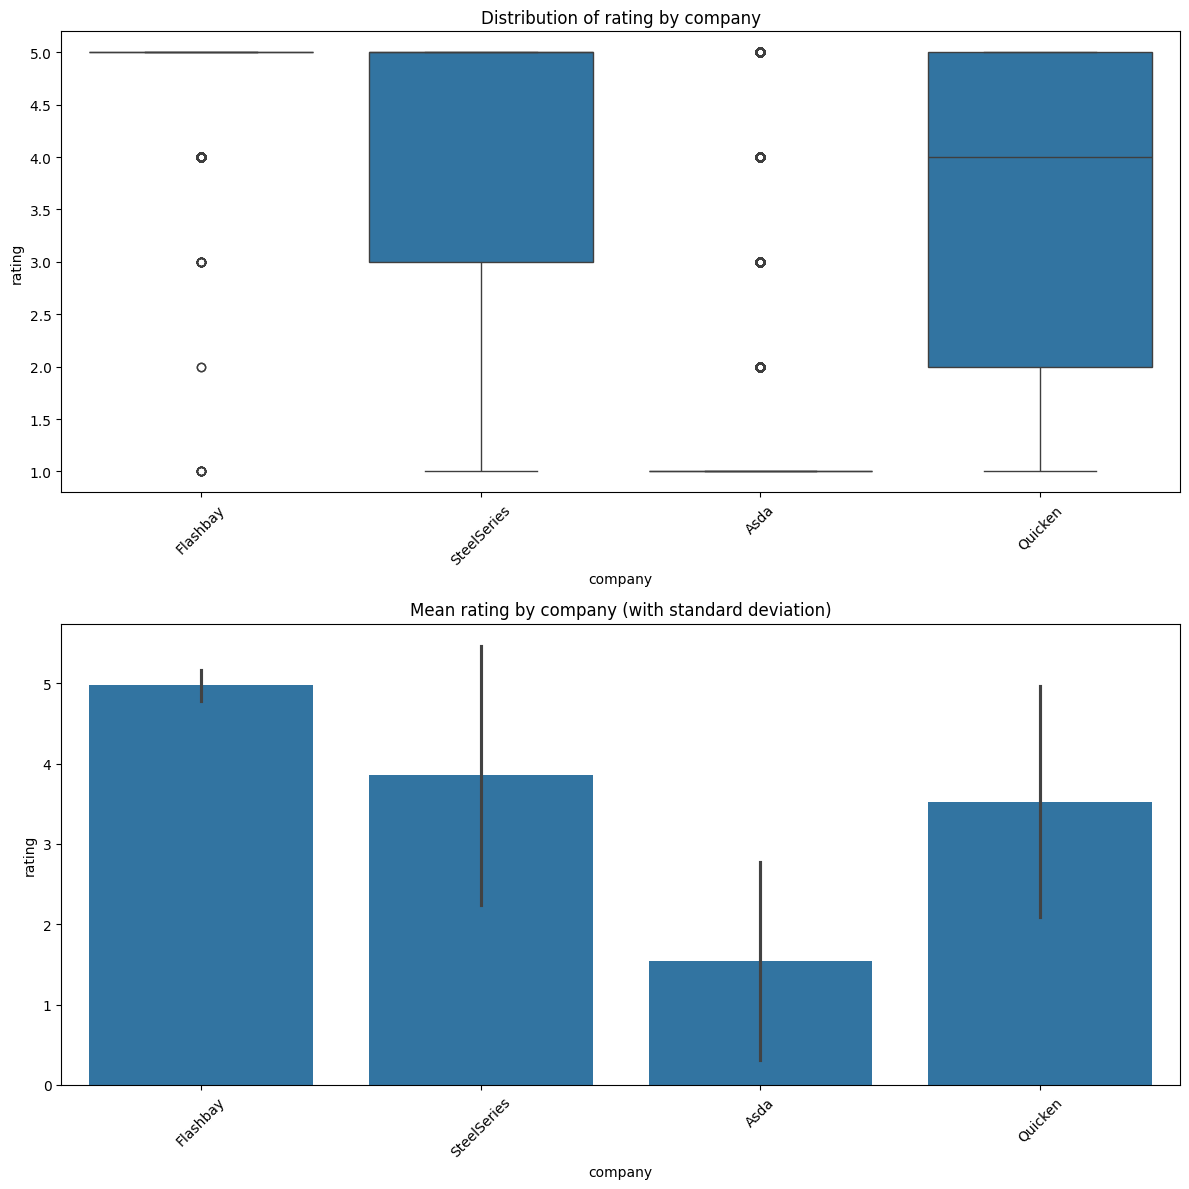


Summary Statistics for Top 10 Categories:
             mean   std  count    se
company                             
Asda         1.54  1.23  15657  0.01
Flashbay     4.97  0.19  17675  0.00
Quicken      3.52  1.44  29466  0.01
SteelSeries  3.85  1.61  15606  0.01

Detailed Company Analysis:

Quicken:
Total reviews: 29,466
Average rating: 3.52
Rating trend (start to end): -0.02
Most recent average (last 3 months): 2.56

Flashbay:
Total reviews: 17,675
Average rating: 4.97
Rating trend (start to end): 0.00
Most recent average (last 3 months): 4.93

Asda:
Total reviews: 15,657
Average rating: 1.54
Rating trend (start to end): -0.84
Most recent average (last 3 months): 3.79

SteelSeries:
Total reviews: 15,606
Average rating: 3.85
Rating trend (start to end): -1.93
Most recent average (last 3 months): 2.64
None


In [284]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[3], target='rating'))

In [285]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[4], target='rating'))


MULTIVARIATE ANALYSIS FOR subject
Skipping text analysis column
None


In [286]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[5], target='rating'))


MULTIVARIATE ANALYSIS FOR text
Skipping text analysis column
None


In [287]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[6], target='rating'))


MULTIVARIATE ANALYSIS FOR answer
Skipping text analysis column
None



MULTIVARIATE ANALYSIS FOR answered

Binary Variable Analysis:


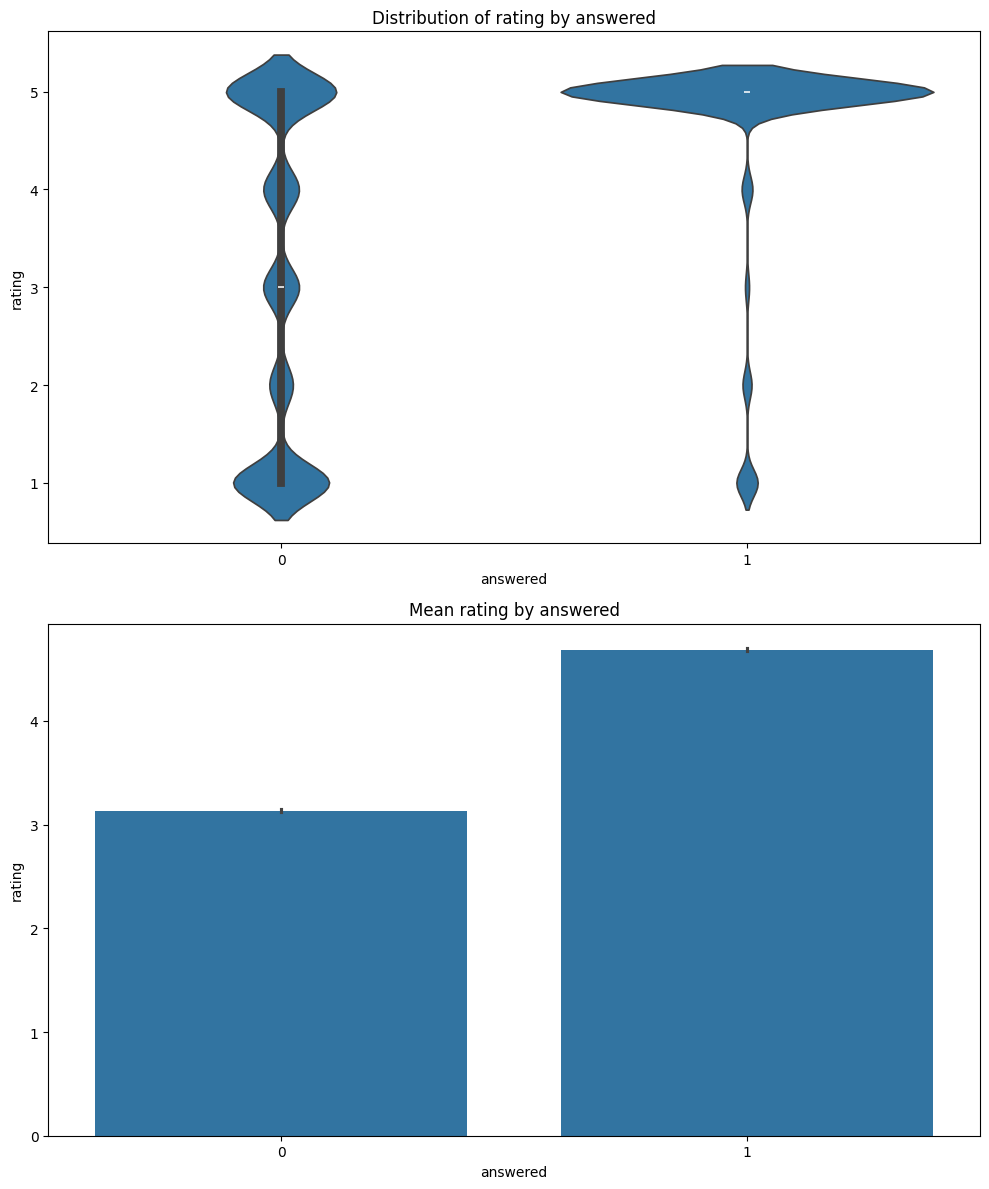


Summary Statistics by Group:
          count  mean  median   std
answered                           
0         58929  3.14     3.0  1.71
1         19475  4.69     5.0  0.99

Difference in means (1 - 0): 1.55

Distribution of ratings by group:
rating        1     2      3      4      5
answered                                  
0         31.84  7.82  11.92  11.83  36.60
1          5.09  2.16   0.96   2.58  89.22
None


In [288]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[7], target='rating'))


MULTIVARIATE ANALYSIS FOR local_date_posted


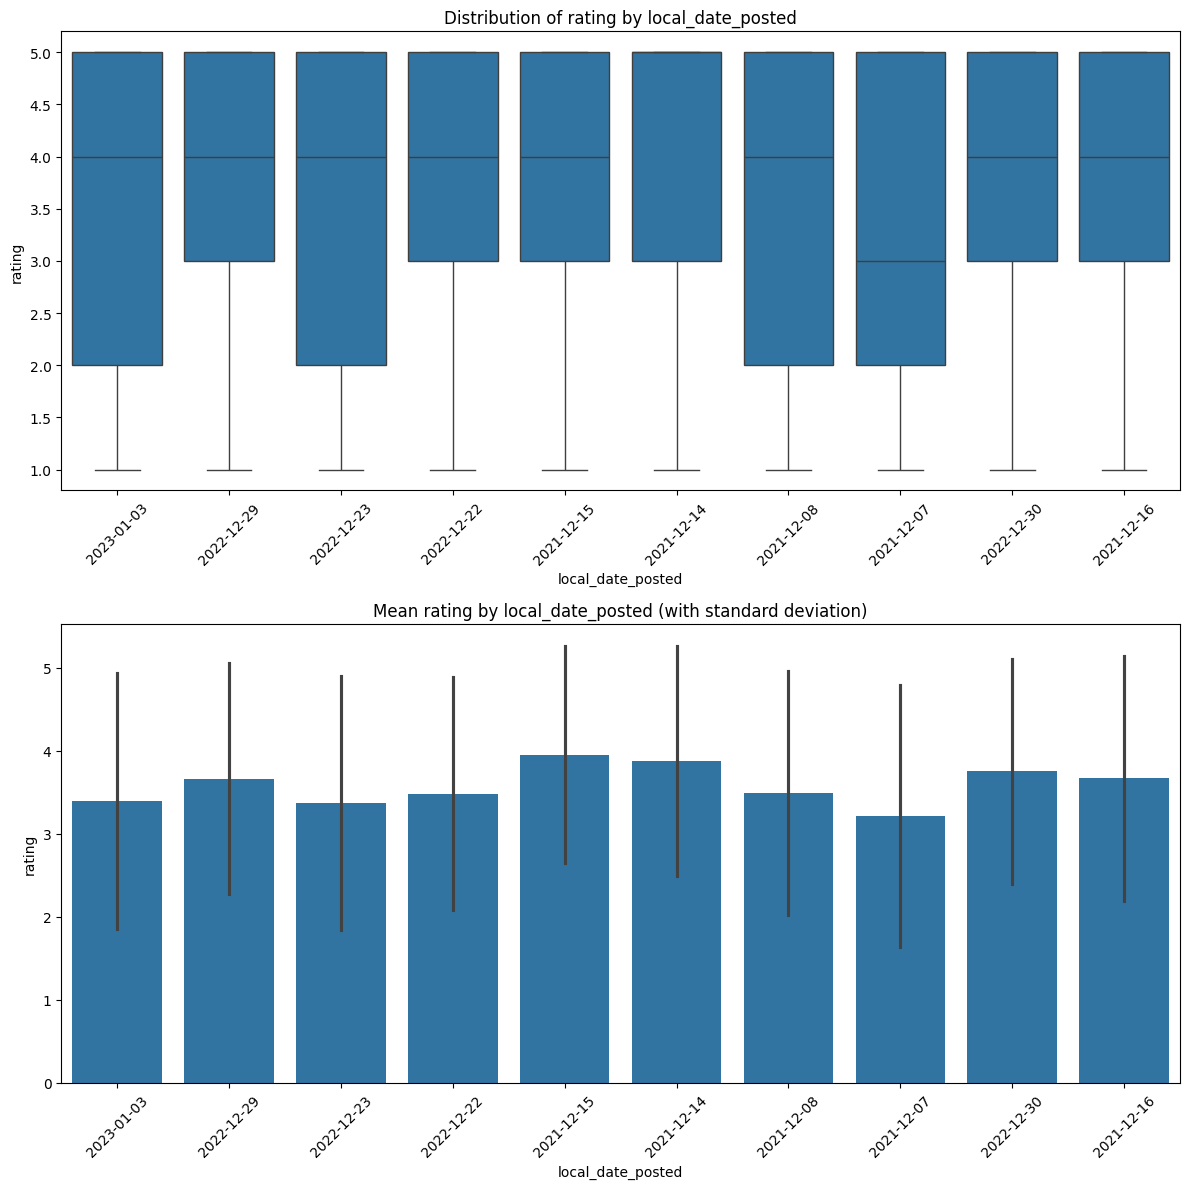


Summary Statistics for Top 10 Categories:
                   mean   std  count    se
local_date_posted                         
2021-12-07         3.21  1.57   1094  0.05
2021-12-08         3.49  1.47   1196  0.04
2021-12-14         3.88  1.39    904  0.05
2021-12-15         3.95  1.30   1133  0.04
2021-12-16         3.67  1.47    156  0.12
2022-12-22         3.48  1.40    552  0.06
2022-12-23         3.37  1.53    315  0.09
2022-12-29         3.66  1.39    241  0.09
2022-12-30         3.75  1.36    282  0.08
2023-01-03         3.39  1.54    171  0.12
None


In [289]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[8], target='rating'))


MULTIVARIATE ANALYSIS FOR day_type

Binary Variable Analysis:


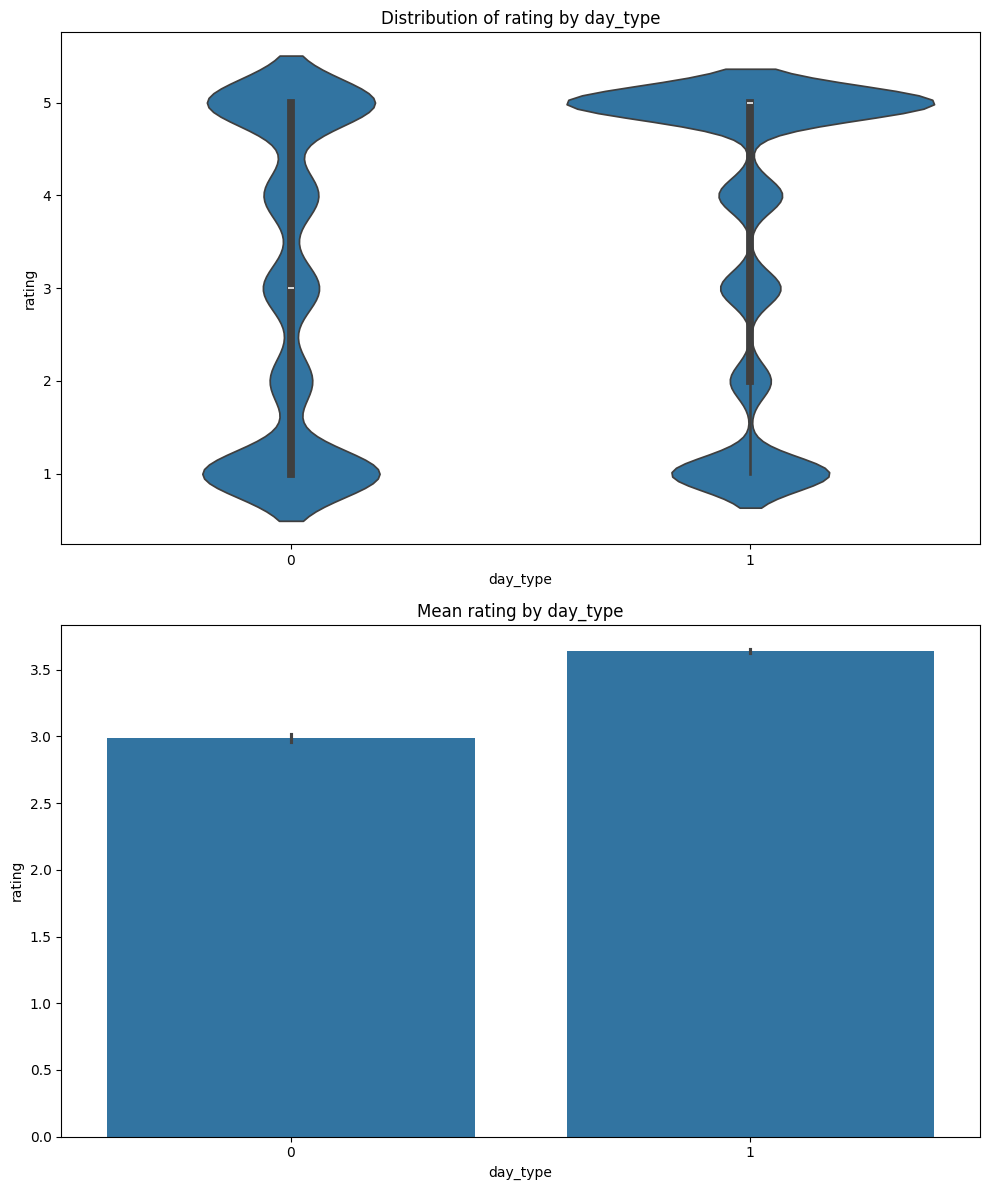


Summary Statistics by Group:
          count  mean  median   std
day_type                           
0         14452  2.99     3.0  1.72
1         63952  3.64     5.0  1.67

Difference in means (1 - 0): 0.65

Distribution of ratings by group:
rating        1     2      3      4      5
day_type                                  
0         35.52  8.52  11.27  10.98  33.70
1         22.86  5.94   8.73   9.20  53.28
None


In [290]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[9], target='rating'))


MULTIVARIATE ANALYSIS FOR review_time

Binary Variable Analysis:


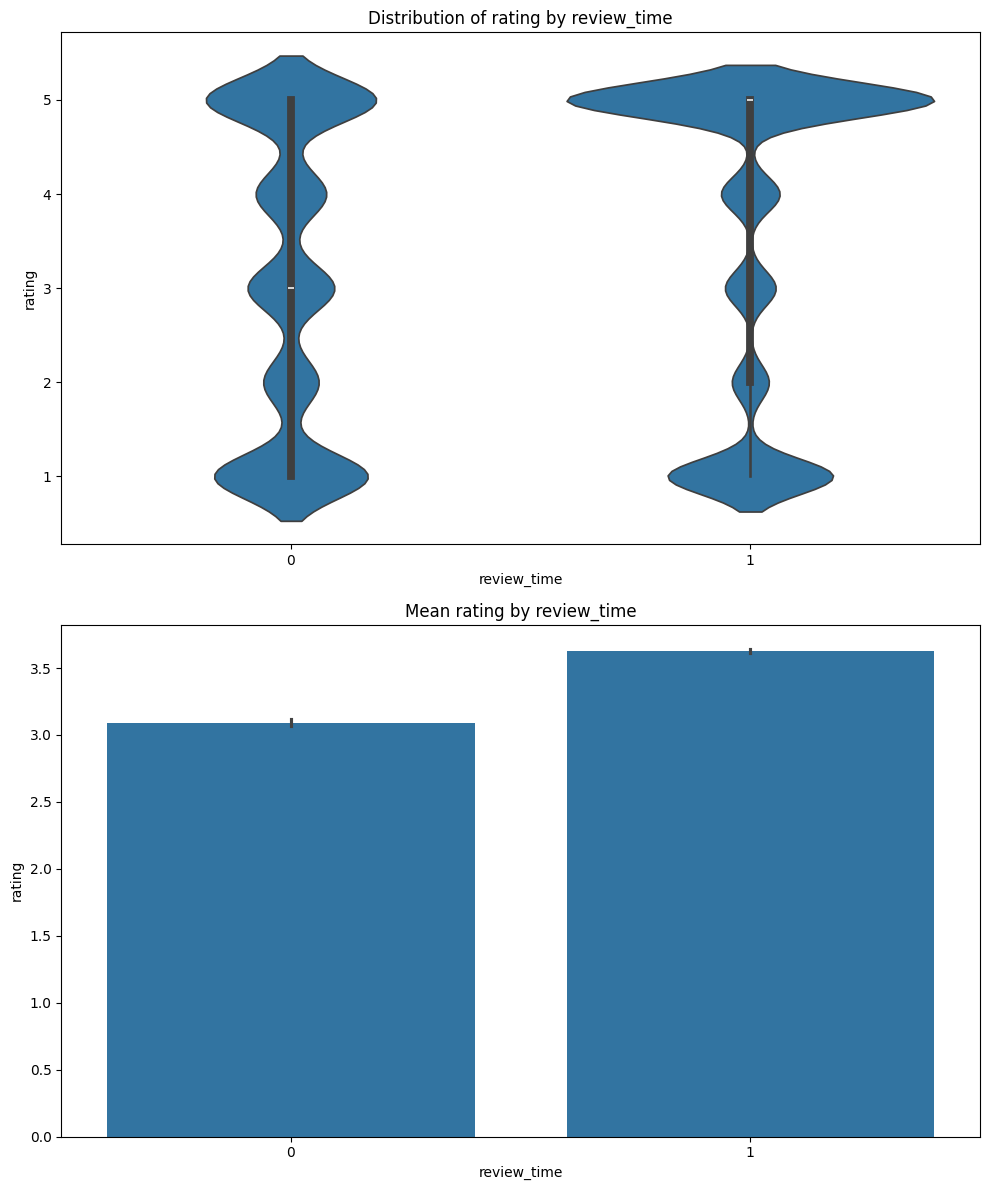


Summary Statistics by Group:
             count  mean  median   std
review_time                           
0            15540  3.09     3.0  1.63
1            62864  3.63     5.0  1.70

Difference in means (1 - 0): 0.54

Distribution of ratings by group:
rating           1      2      3      4      5
review_time                                   
0            28.63  10.32  16.16  13.15  31.74
1            24.34   5.45   7.47   8.64  54.10
None


In [291]:
print(analyze_multivariate(df_trustpilot, univariate_features.columns[10], target='rating'))

In [292]:
print(df_trustpilot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78404 entries, 0 to 78403
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   rating                   78404 non-null  int64         
 1   location                 78404 non-null  object        
 2   username                 78401 non-null  object        
 3   verification             78404 non-null  int64         
 4   repeat_reviewer_encoded  78404 non-null  int64         
 5   company                  78404 non-null  object        
 6   subject                  78404 non-null  object        
 7   text                     78404 non-null  object        
 8   answer                   78404 non-null  object        
 9   answered                 78404 non-null  int64         
 10  local_date_posted        78404 non-null  datetime64[ns]
 11  month_posted             78404 non-null  int64         
 12  local_hour               78404 n

In [293]:
#Split set into numeric, categorical and datetime variables
#Provide statistical metrics for numeric variables

numeric_variables = df_trustpilot.select_dtypes(include = ['int', 'float'])
categorical_variables = df_trustpilot.select_dtypes(include=['object']) 
datetime_variables = df_trustpilot.select_dtypes(include=['datetime64'])

STAGE 3 - TIME SERIES PLOT

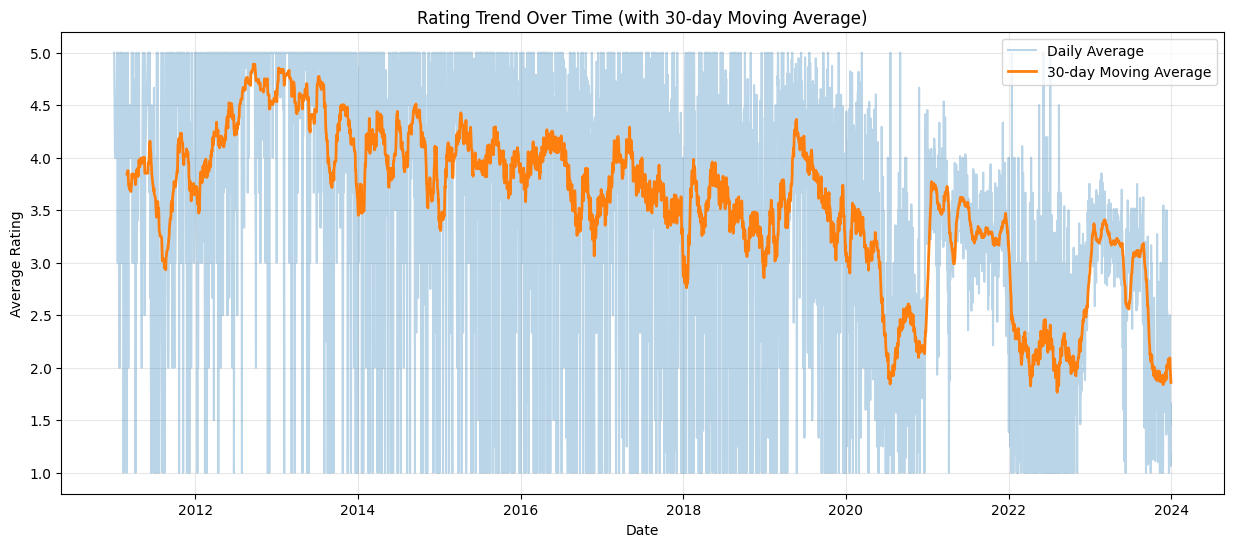

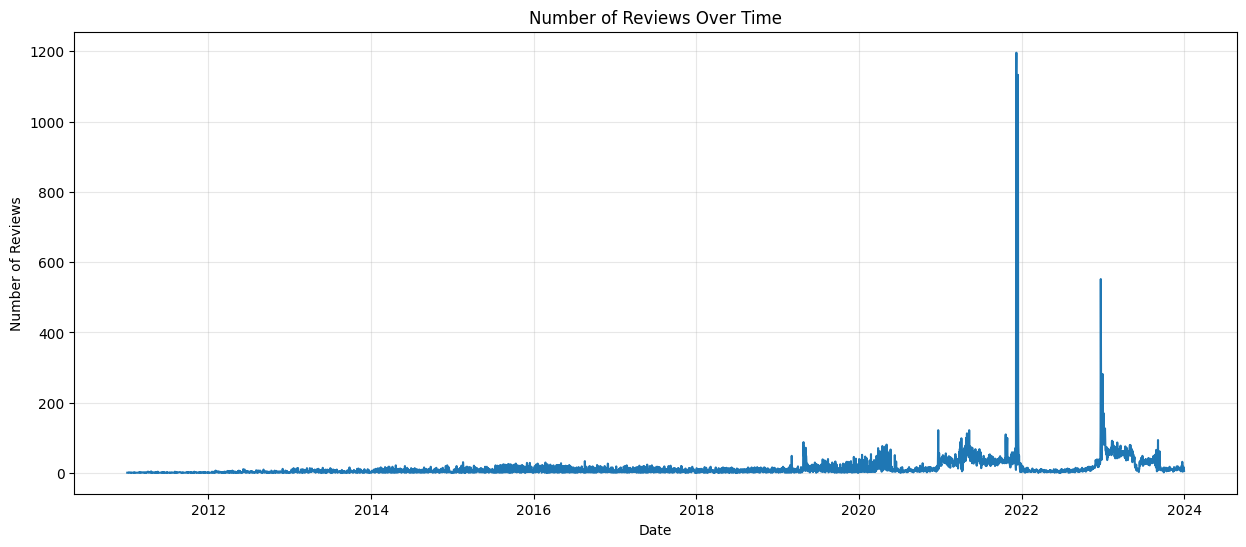

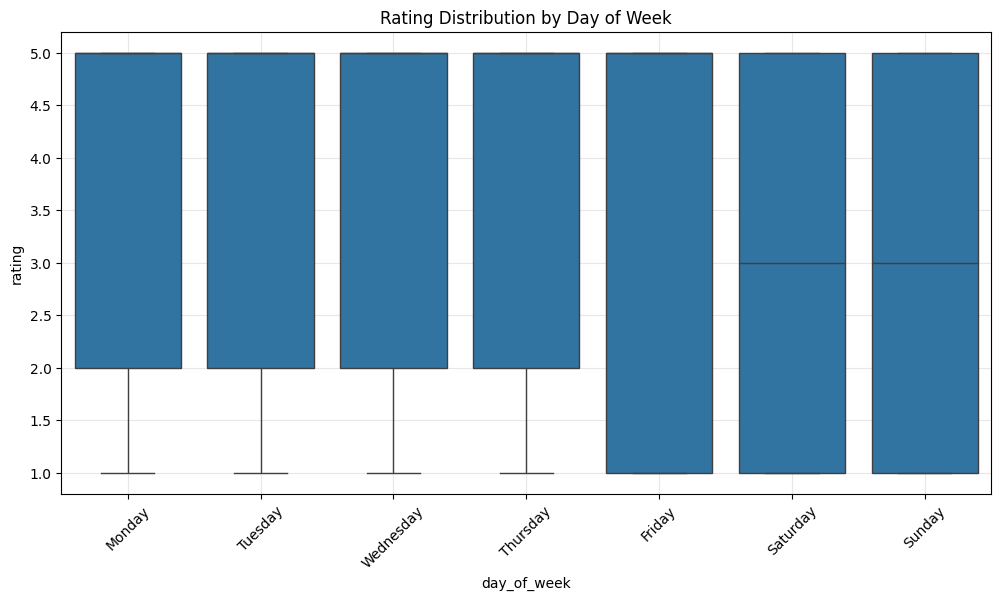

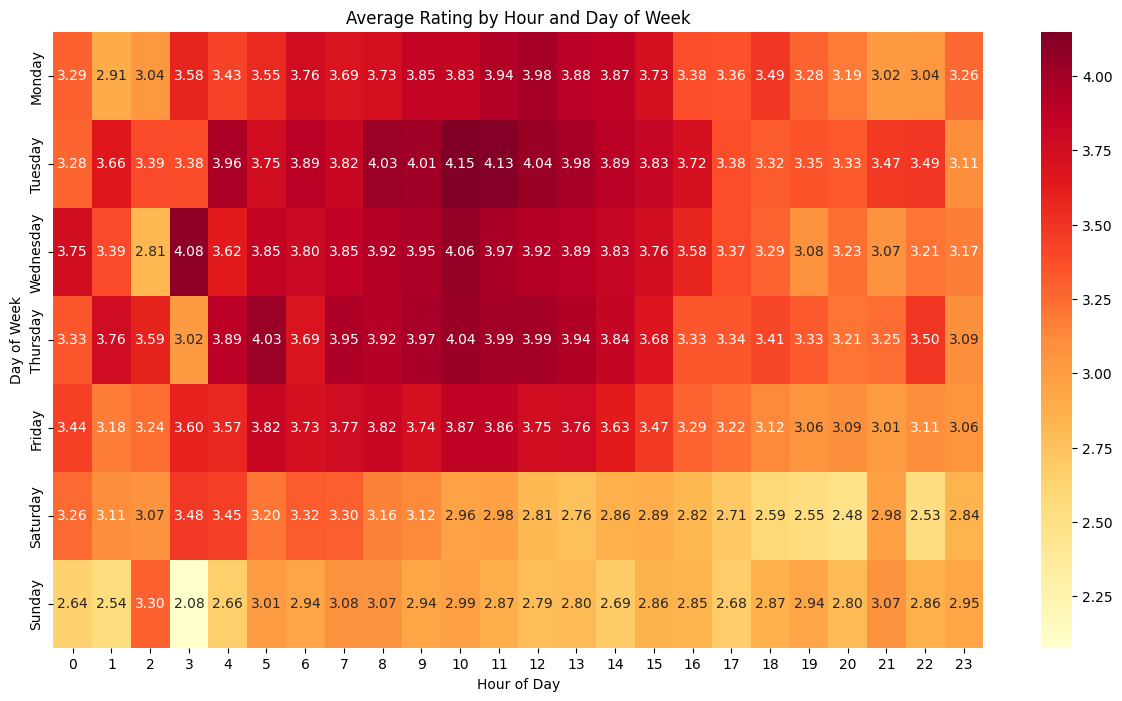


Time Series Statistics:
Start Date: 2011-01-02 00:00:00
End Date: 2023-12-31 00:00:00

Busiest Day: 2021-12-08 00:00:00 with 1196 reviews
Best Rating Day: 2011-01-02 00:00:00 with average rating of 5.00
Worst Rating Day: 2011-02-13 00:00:00 with average rating of 1.00


In [294]:

# Define reasonable date range
start_date = '2011-01-01'
end_date = '2023-12-31'

# Filter the data
filtered_df = df_trustpilot[
    (df_trustpilot['local_date_posted'] >= start_date) & 
    (df_trustpilot['local_date_posted'] <= end_date)
]

# 1. Daily Average Rating Over Time (actual time series)
daily_avg = filtered_df.groupby('local_date_posted')['rating'].mean()


# 2. Rolling Average to Smooth Daily Fluctuations
plt.figure(figsize=(15, 6))
rolling_avg = daily_avg.rolling(window=30).mean()  # 30-day moving average
plt.plot(daily_avg.index, daily_avg.values, alpha=0.3, label='Daily Average')
plt.plot(rolling_avg.index, rolling_avg.values, linewidth=2, label='30-day Moving Average')
plt.title('Rating Trend Over Time (with 30-day Moving Average)')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Volume of Reviews Over Time
plt.figure(figsize=(15, 6))
daily_count = filtered_df.groupby('local_date_posted').size()
plt.plot(daily_count.index, daily_count.values)
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True, alpha=0.3)
plt.show()

# 4. Day of Week Analysis
plt.figure(figsize=(12, 6))
filtered_df['day_of_week'] = filtered_df['local_date_posted'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=filtered_df, x='day_of_week', y='rating', order=day_order)
plt.title('Rating Distribution by Day of Week')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# 5. Heatmap: Hour vs Day of Week
plt.figure(figsize=(15, 8))
pivot_table = filtered_df.pivot_table(
    values='rating',
    index=filtered_df['local_date_posted'].dt.day_name(),
    columns='local_hour',
    aggfunc='mean'
)
pivot_table = pivot_table.reindex(day_order)  # Reorder days
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Average Rating by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


# Print some summary statistics
print("\nTime Series Statistics:")
print(f"Start Date: {filtered_df['local_date_posted'].min()}")
print(f"End Date: {filtered_df['local_date_posted'].max()}")
print(f"\nBusiest Day: {daily_count.idxmax()} with {daily_count.max()} reviews")
print(f"Best Rating Day: {daily_avg.idxmax()} with average rating of {daily_avg.max():.2f}")
print(f"Worst Rating Day: {daily_avg.idxmin()} with average rating of {daily_avg.min():.2f}")

STAGE 4 - GROUPBY ANALYSES

LOCATION ANALYSIS

Basic Location Metrics:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Repeat_Reviewers  Pct_Verified
location                                                                                          
AU                  381       3.714       1.689            5.0                 0.375         0.677
CA                 1703       3.812       1.571            5.0                 0.248         0.766
DE                  871       4.087       1.437            5.0                 0.382         0.731
DK                  261       3.621       1.686            5.0                 0.782         0.471
FR                  491       4.122       1.453            5.0                 0.456         0.633
GB                17377       1.781       1.460            1.0                 0.810         0.073
NL                  447       3.984       1.529            5.0                 0.595         0.617
PL                  293       4.246       1.370            5.0    

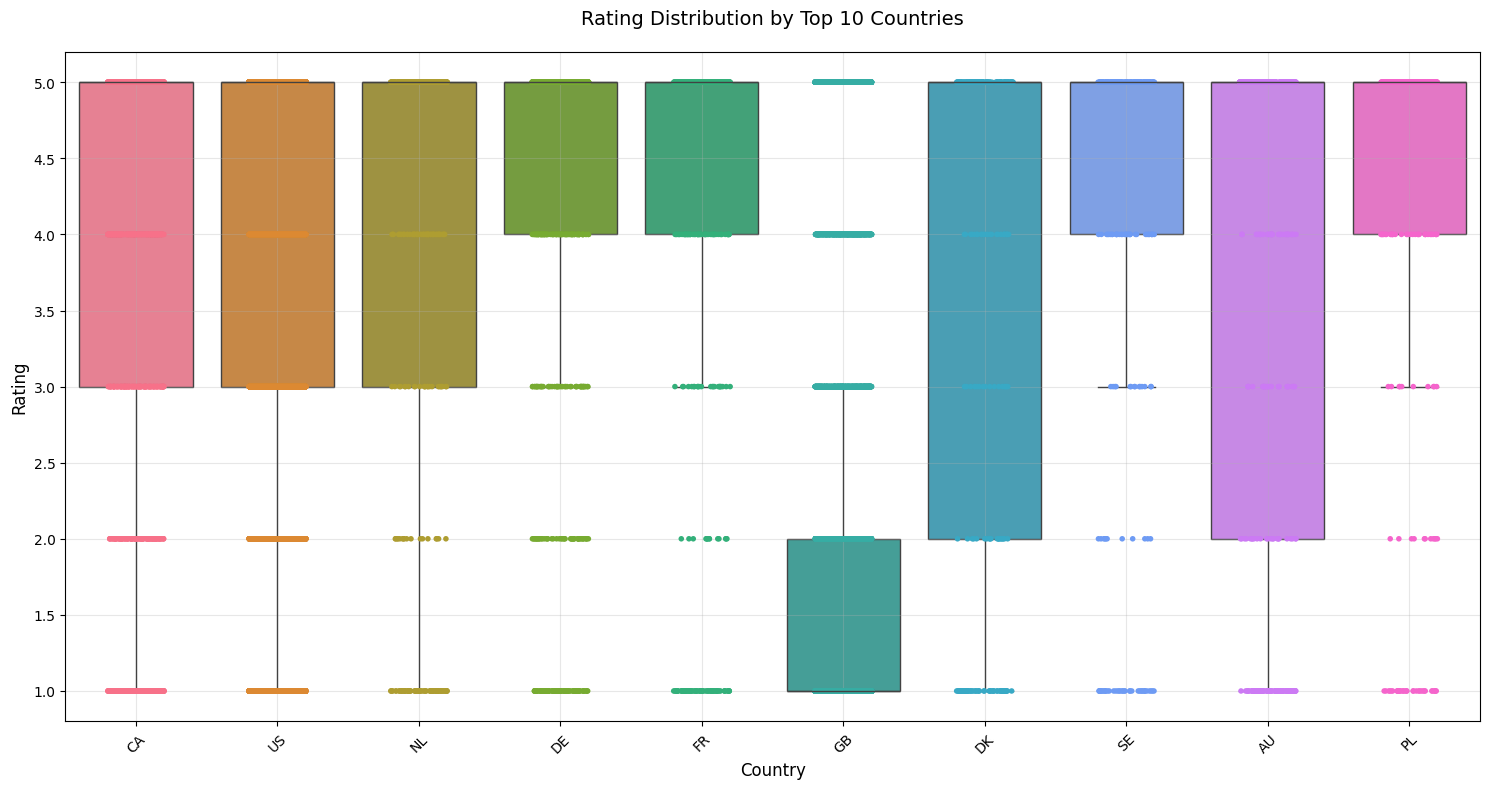

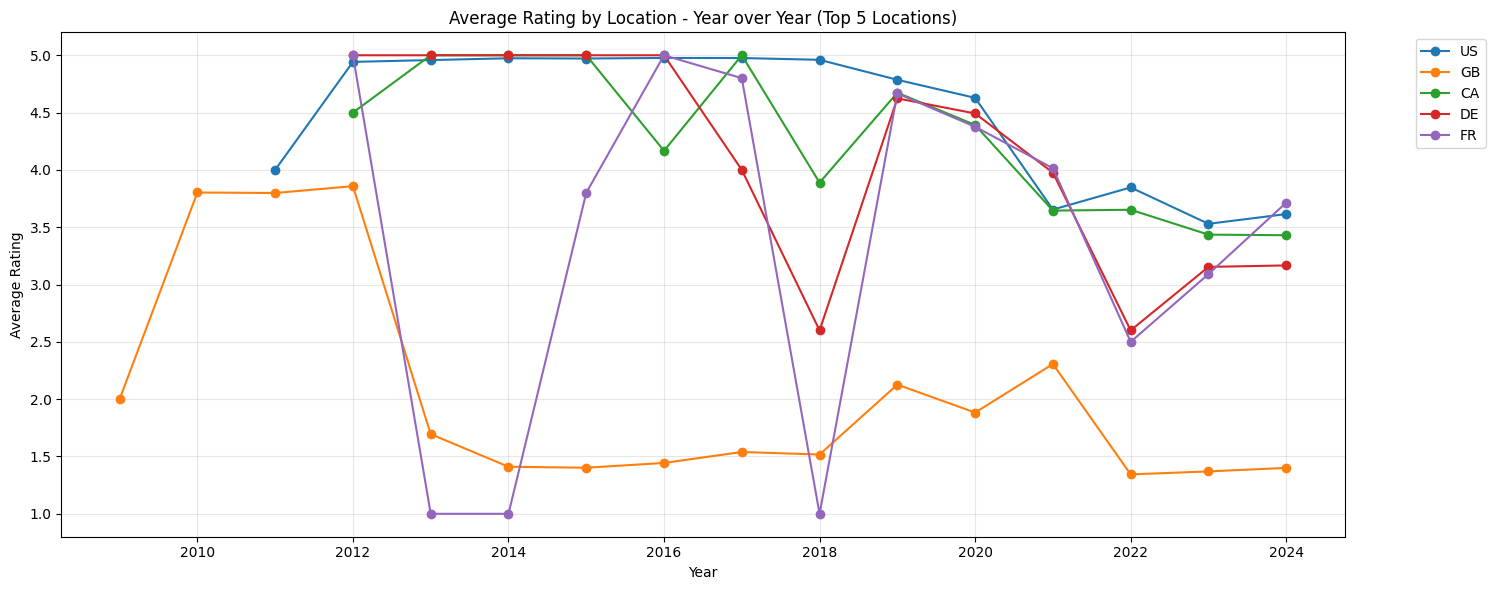

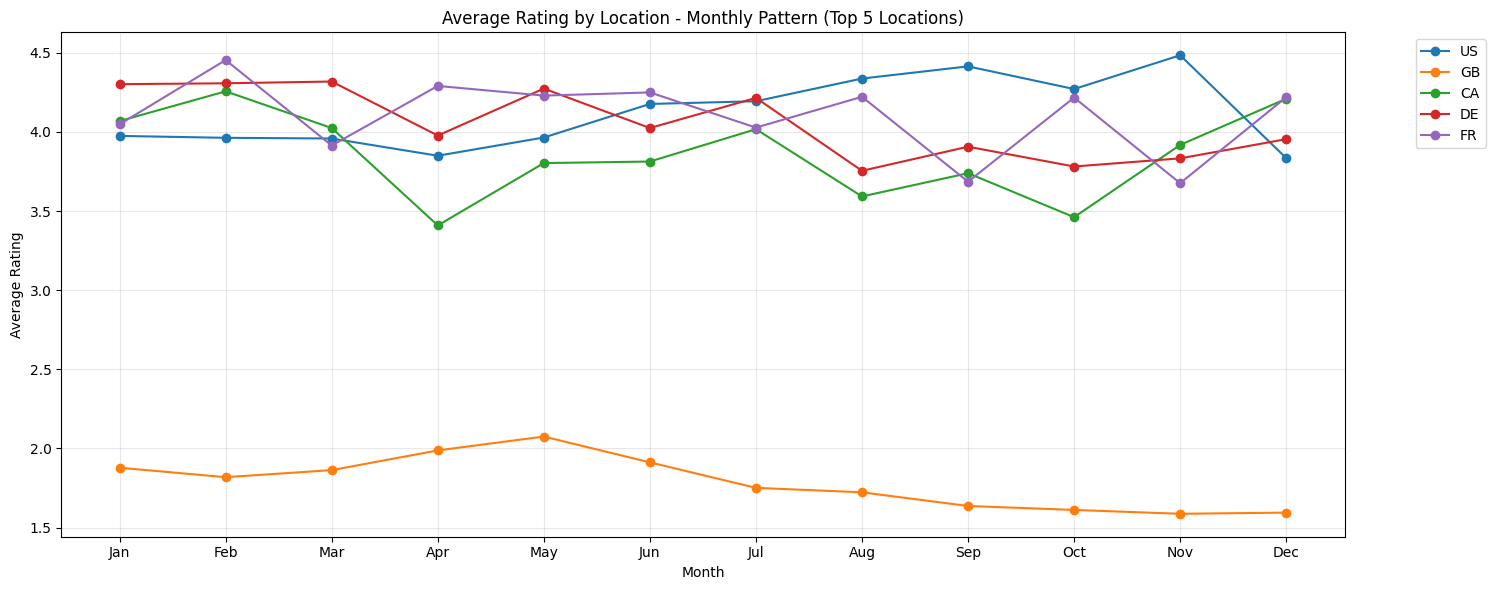


Summary Statistics by Location:
          count  mean  median   std
location                           
AU          381  3.71     5.0  1.69
CA         1703  3.81     5.0  1.57
DE          871  4.09     5.0  1.44
DK          261  3.62     5.0  1.69
FR          491  4.12     5.0  1.45
GB        17377  1.78     1.0  1.46
NL          447  3.98     5.0  1.53
PL          293  4.25     5.0  1.37
SE          271  4.08     5.0  1.47
US        52431  4.03     5.0  1.39


In [295]:
# Location

print("LOCATION ANALYSIS")
print("="*80)

# Get top 10 locations and filter DataFrame
top_locations = df_trustpilot['location'].value_counts().head(10).index
df_filtered = df_trustpilot[df_trustpilot['location'].isin(top_locations)]

# Basic metrics by location
location_analysis = df_filtered.groupby('location').agg({
    'rating': ['count', 'mean', 'std', 'median'],
    'repeat_reviewer_encoded': 'mean',
    'verification': 'mean'
}).round(3)

# Rename columns
location_analysis.columns = ['Total_Reviews', 'Avg_Rating', 'Std_Rating', 'Median_Rating', 
                           'Pct_Repeat_Reviewers', 'Pct_Verified']
print("\nBasic Location Metrics:")
print(location_analysis)

# Day of week distribution by location
day_distribution = pd.crosstab(df_filtered['location'], 
                              df_filtered['day_of_week_posted'], 
                              normalize='index').round(3) * 100
print("\nDay of Week Distribution by Location (%):")
print(day_distribution)

# Time of day distribution by location
time_distribution = pd.crosstab(df_filtered['location'], 
                               df_filtered['time_of_day'], 
                               normalize='index').round(3) * 100
print("\nTime of Day Distribution by Location (%):")
print(time_distribution)

# Rating distribution by location
rating_distribution = pd.crosstab(df_filtered['location'], 
                                 df_filtered['rating'], 
                                 normalize='index').round(3) * 100
print("\nRating Distribution by Location (%):")
print(rating_distribution)

# Recent trends (last 90 days)
recent_cutoff = df_filtered['local_date_posted'].max() - pd.Timedelta(days=90)
recent_data = df_filtered[df_filtered['local_date_posted'] >= recent_cutoff]

recent_analysis = recent_data.groupby('location').agg({
    'rating': ['count', 'mean'],
    'verification': 'mean',
    'repeat_reviewer_encoded': 'mean'
}).round(3)

recent_analysis.columns = ['Recent_Review_Count', 'Recent_Avg_Rating', 
                         'Recent_Verification_Rate', 'Recent_Repeat_Reviewer_Rate']
print("\nRecent 90-Day Metrics by Location:")
print(recent_analysis)

# Your original rating distribution plot
colors = sns.color_palette("husl", n_colors=len(top_locations))
plt.figure(figsize=(15, 8))
# Create boxplot
sns.boxplot(x='location', y='rating', data=df_filtered,
            palette=colors,
            boxprops={'zorder': 1},
            showfliers=False)
# Add stripplot on top
sns.stripplot(x='location', y='rating', data=df_filtered,
              palette=colors,
              size=4,
              jitter=0.2,
              zorder=2)
plt.title('Rating Distribution by Top 10 Countries', fontsize=14, pad=20)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Get top 5 locations for trend analysis
top_5_locations = df_trustpilot['location'].value_counts().head(5).index
df_filtered_top5 = df_filtered[df_filtered['location'].isin(top_5_locations)]

# Year over Year Analysis (Top 5)
plt.figure(figsize=(15, 6))
for location in top_5_locations:
    yearly_avg = df_filtered_top5[df_filtered_top5['location'] == location].groupby(
        df_filtered_top5['local_date_posted'].dt.year)['rating'].mean()
    plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=location)

plt.title('Average Rating by Location - Year over Year (Top 5 Locations)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Month over Month Analysis (Top 5) - Focusing only on months
plt.figure(figsize=(15, 6))
for location in top_5_locations:
    location_data = df_filtered_top5[df_filtered_top5['location'] == location]
    # Group by month number only
    monthly_avg = location_data.groupby(
        location_data['local_date_posted'].dt.month)['rating'].mean()
    plt.plot(range(1, 13), monthly_avg, marker='o', label=location)

plt.title('Average Rating by Location - Monthly Pattern (Top 5 Locations)')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.xticks(range(1, 13), 
          ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSummary Statistics by Location:")
print(df_filtered.groupby('location')['rating'].agg(['count', 'mean', 'median', 'std']).round(2))

USERNAME ANALYSIS

Analyzing user patterns for top 10 companies:
company
Quicken        29466
Flashbay       17675
Asda           15657
SteelSeries    15606
Name: count, dtype: int64

USER ANALYSIS FOR Quicken

Top 5 reviewers for Quicken:
username
Customer    595
John        114
David        82
Michael      77
Richard      62
Name: count, dtype: int64

Reviewer Metrics for Quicken:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Verified  Pct_Repeat_Reviewer
username                                                                                         
Customer            595       3.539       1.356            4.0         0.755                0.679
David                82       3.500       1.434            4.0         0.671                0.744
John                114       3.482       1.403            4.0         0.711                0.746
Michael              77       3.260       1.427            3.0         0.740                0.779
Richard              62   

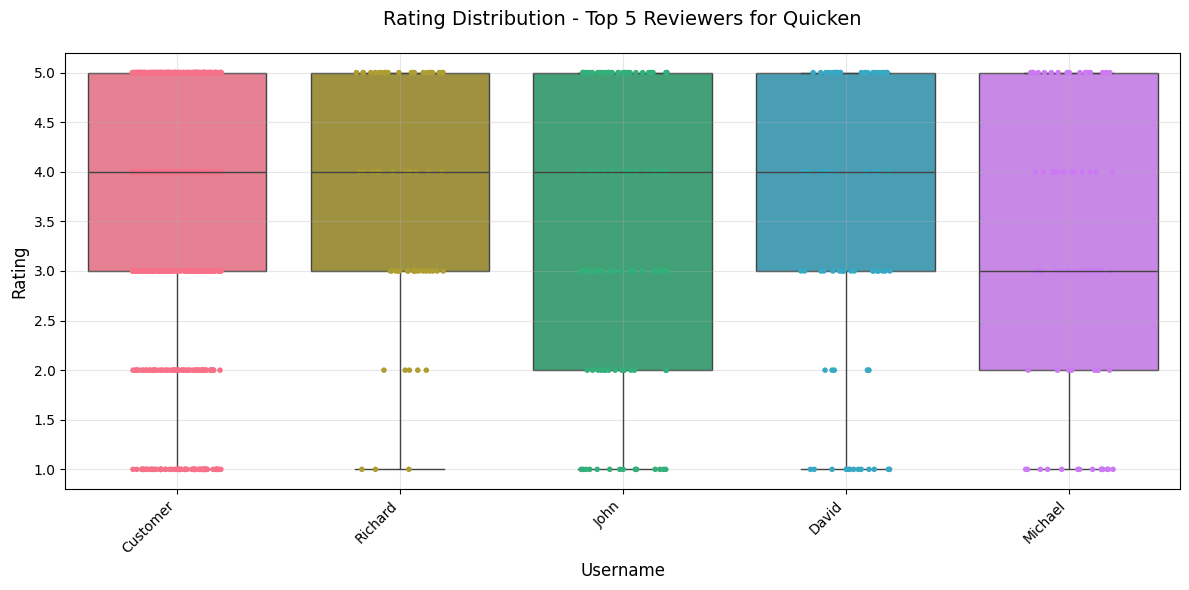

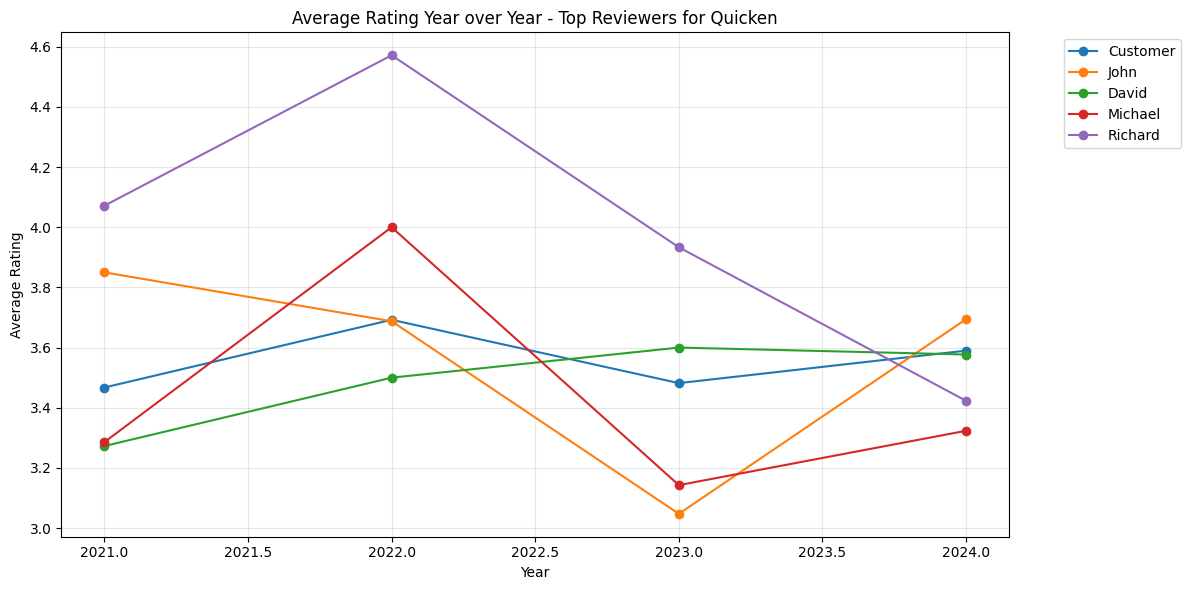

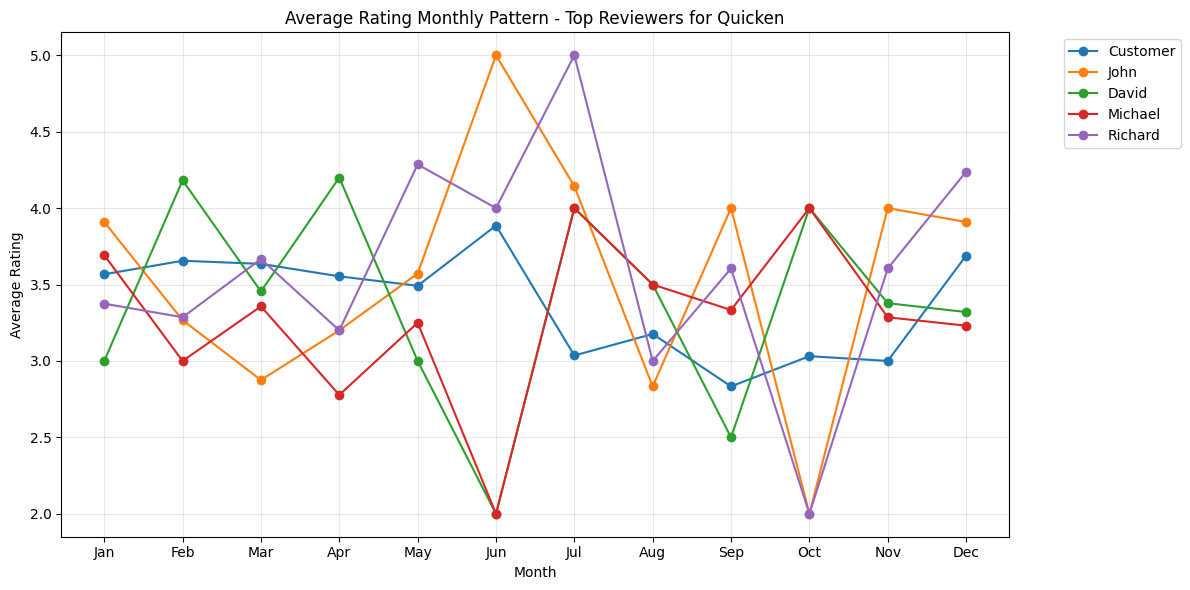


USER ANALYSIS FOR Flashbay

Top 5 reviewers for Flashbay:
username
Customer          153
Jessica            21
Chris              18
Happy Customer     17
Brian              16
Name: count, dtype: int64

Reviewer Metrics for Flashbay:
                Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Verified  Pct_Repeat_Reviewer
username                                                                                               
Brian                      16       4.938       0.250            5.0         1.000                0.250
Chris                      18       5.000       0.000            5.0         0.944                0.167
Customer                  153       4.967       0.212            5.0         0.987                0.183
Happy Customer             17       5.000       0.000            5.0         1.000                0.118
Jessica                    21       5.000       0.000            5.0         1.000                0.143


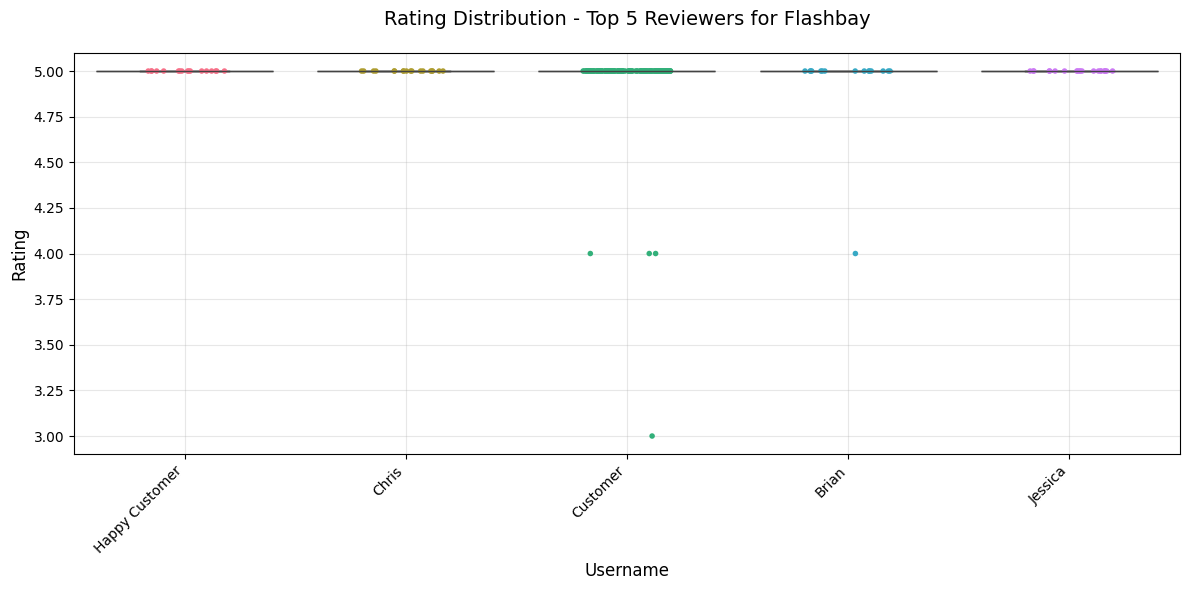

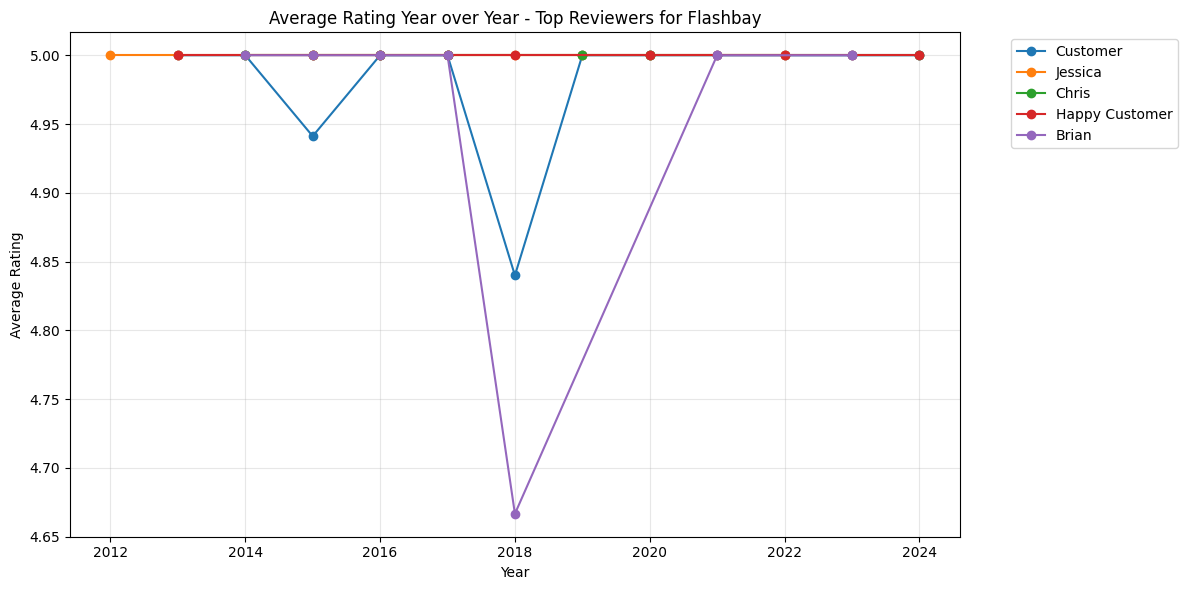

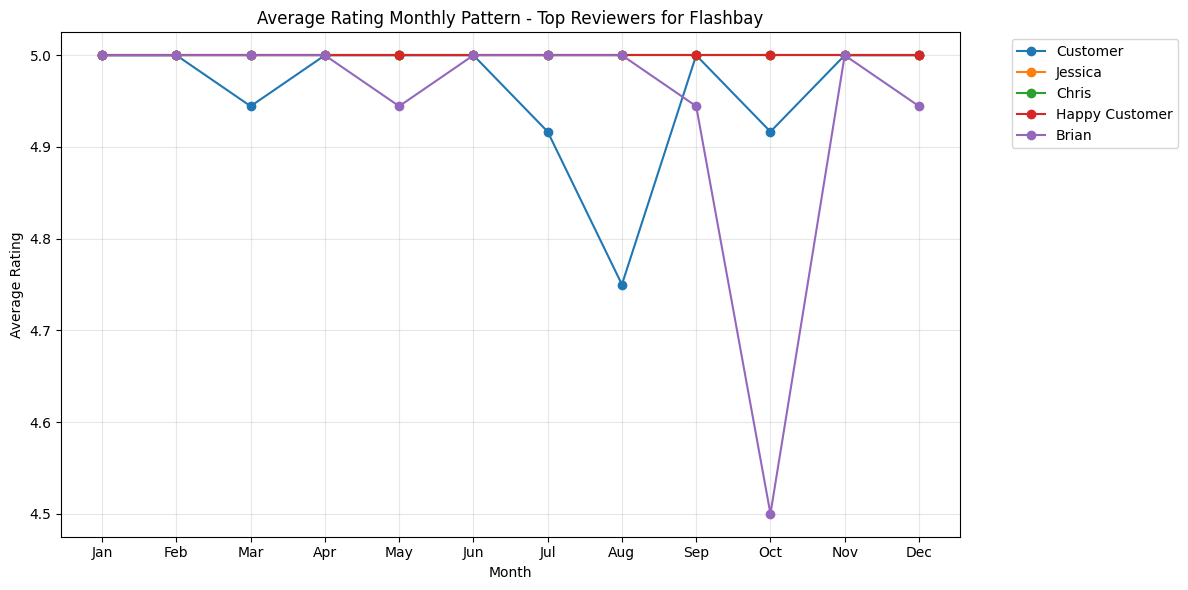


USER ANALYSIS FOR Asda

Top 5 reviewers for Asda:
username
Customer    185
Paul         50
Consumer     48
John         41
David        34
Name: count, dtype: int64

Reviewer Metrics for Asda:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Verified  Pct_Repeat_Reviewer
username                                                                                         
Consumer             48       1.417       1.088            1.0           0.0                0.625
Customer            185       1.514       1.203            1.0           0.0                0.973
David                34       2.235       1.653            1.0           0.0                0.971
John                 41       1.829       1.465            1.0           0.0                0.976
Paul                 50       1.500       1.165            1.0           0.0                0.920


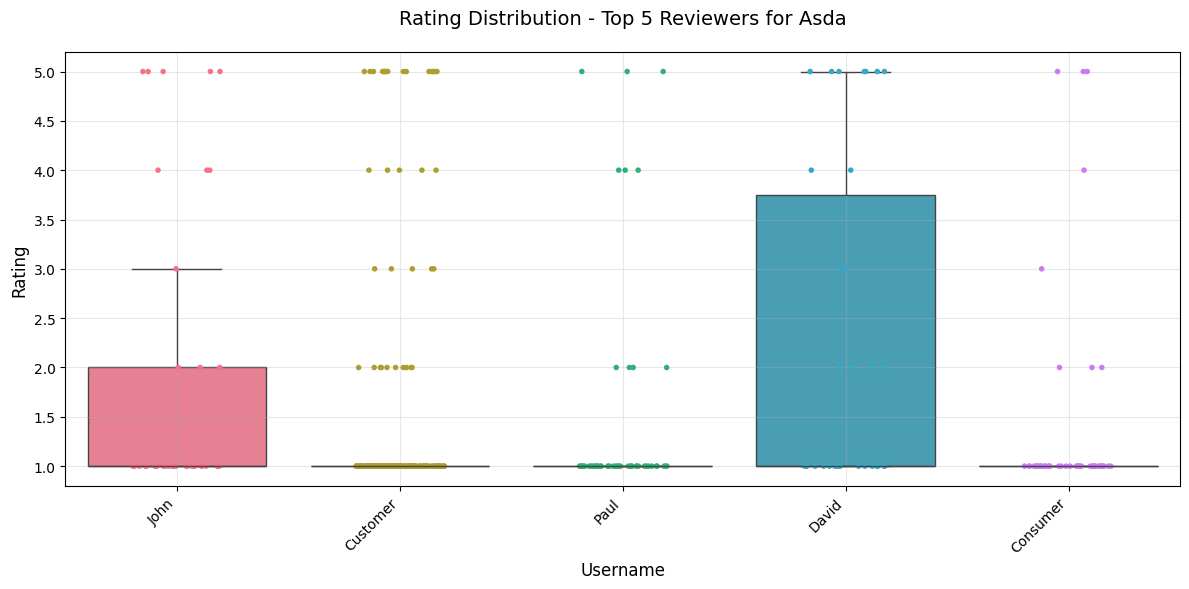

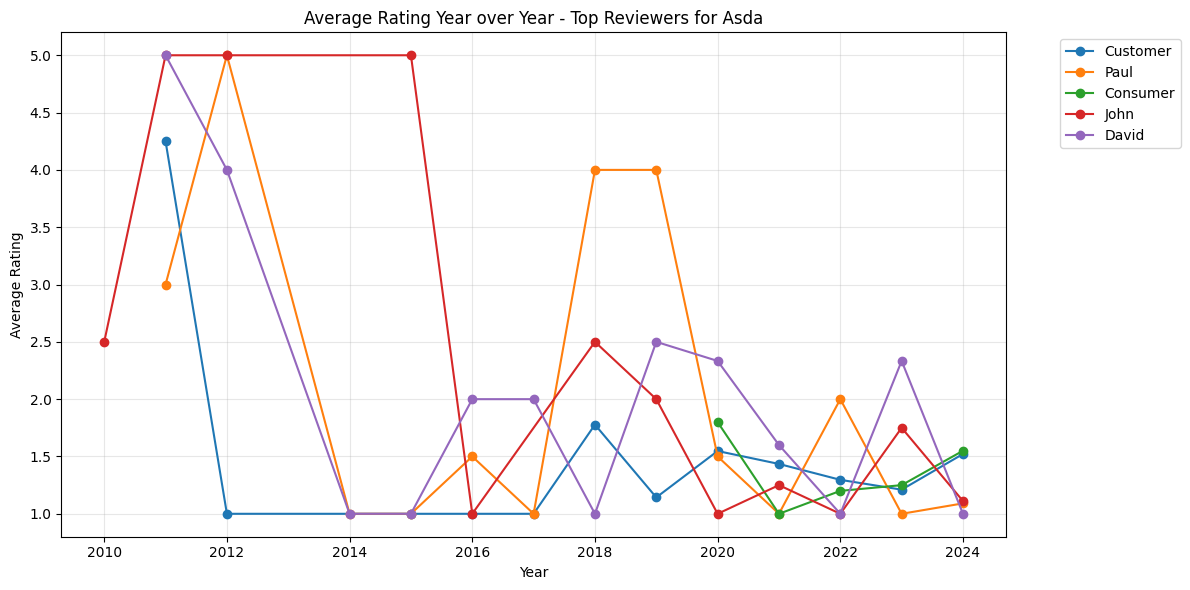

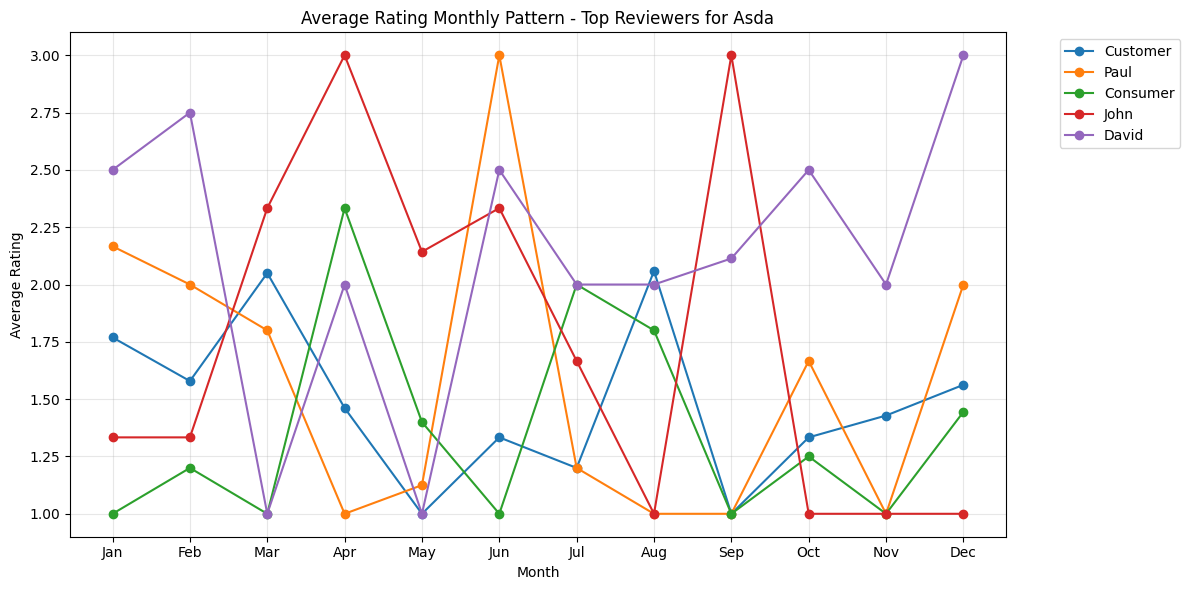


USER ANALYSIS FOR SteelSeries

Top 5 reviewers for SteelSeries:
username
Customer    144
Alex         61
Chris        59
Daniel       54
David        51
Name: count, dtype: int64

Reviewer Metrics for SteelSeries:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Verified  Pct_Repeat_Reviewer
username                                                                                         
Alex                 61       3.934       1.548            5.0         0.770                0.262
Chris                59       3.407       1.782            4.0         0.831                0.288
Customer            144       3.778       1.623            5.0         0.750                0.653
Daniel               54       3.556       1.723            4.0         0.685                0.352
David                51       3.941       1.555            5.0         0.863                0.333


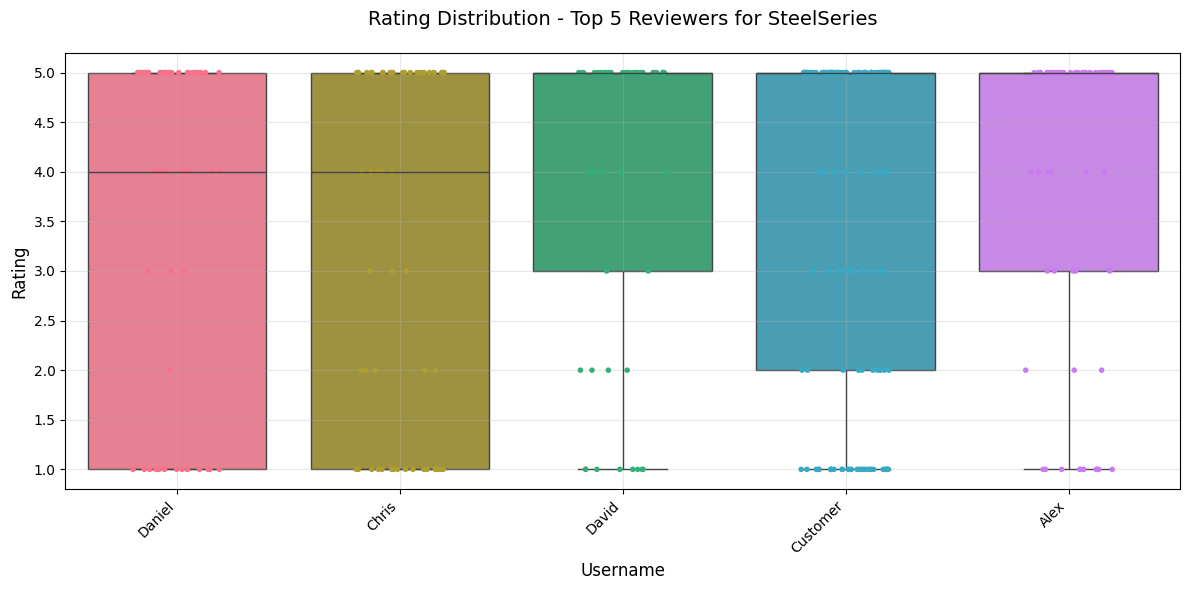

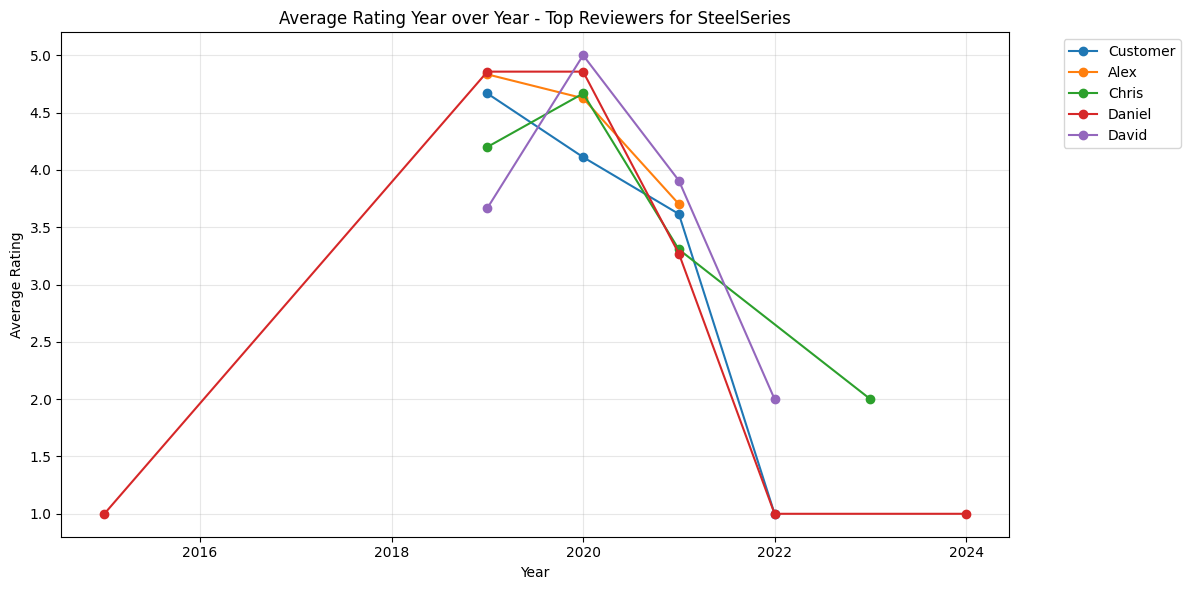

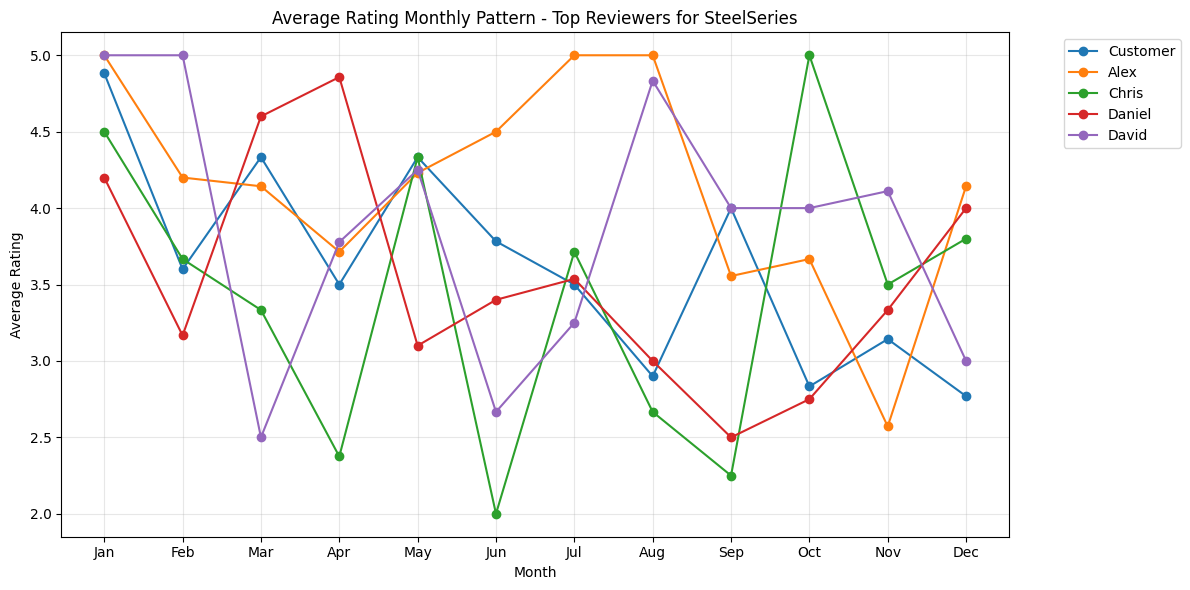

In [296]:
# USERNAME ANALYSIS
print("USERNAME ANALYSIS")
print("="*80)

# First, get top companies
top_companies = df_trustpilot['company'].value_counts().head(10)
print("\nAnalyzing user patterns for top 10 companies:")
print(top_companies)

# For each top company, analyze their top users
for company in top_companies.index:
    print(f"\n{'='*50}")
    print(f"USER ANALYSIS FOR {company}")
    print(f"{'='*50}")
    
    # Filter for current company
    company_data = df_trustpilot[df_trustpilot['company'] == company]
    
    # Get top users for this company
    top_company_users = company_data['username'].value_counts().head(5)
    print(f"\nTop 5 reviewers for {company}:")
    print(top_company_users)
    
    # Filter for these users
    df_filtered = company_data[company_data['username'].isin(top_company_users.index)]
    
    # User analysis for this company
    user_analysis = df_filtered.groupby('username').agg({
        'rating': ['count', 'mean', 'std', 'median'],
        'verification': 'mean',
        'repeat_reviewer_encoded': 'mean'
    }).round(3)
    
    # Rename columns
    user_analysis.columns = ['Total_Reviews', 'Avg_Rating', 'Std_Rating', 'Median_Rating', 
                           'Pct_Verified', 'Pct_Repeat_Reviewer']
    print(f"\nReviewer Metrics for {company}:")
    print(user_analysis)
    
    # Rating distribution plot
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("husl", n_colors=len(top_company_users))
    
    # Create boxplot
    sns.boxplot(x='username', y='rating', data=df_filtered,
                palette=colors,
                boxprops={'zorder': 1},
                showfliers=False)
    
    # Add stripplot
    sns.stripplot(x='username', y='rating', data=df_filtered,
                  palette=colors,
                  size=4,
                  jitter=0.2,
                  zorder=2)
    
    plt.title(f'Rating Distribution - Top 5 Reviewers for {company}', fontsize=14, pad=20)
    plt.xlabel('Username', fontsize=12)
    plt.ylabel('Rating', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Year over Year Analysis
    plt.figure(figsize=(12, 6))
    for user in top_company_users.index:
        user_data = df_filtered[df_filtered['username'] == user]
        yearly_avg = user_data.groupby(
            user_data['local_date_posted'].dt.year)['rating'].mean()
        plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=user)
    
    plt.title(f'Average Rating Year over Year - Top Reviewers for {company}')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Monthly Pattern Analysis
    plt.figure(figsize=(12, 6))
    months = range(1, 13)
    
    for user in top_company_users.index:
        user_data = df_filtered[df_filtered['username'] == user]
        # Create a DataFrame with all months
        monthly_avg = pd.DataFrame(index=months)
        # Calculate averages for available months
        user_monthly = user_data.groupby(
            user_data['local_date_posted'].dt.month)['rating'].mean()
        # Merge with all months
        monthly_avg['rating'] = user_monthly
        # Plot with handling for missing months
        plt.plot(months, monthly_avg['rating'].fillna(monthly_avg['rating'].mean()), 
                marker='o', label=user)
    
    plt.title(f'Average Rating Monthly Pattern - Top Reviewers for {company}')
    plt.xlabel('Month')
    plt.ylabel('Average Rating')
    plt.xticks(months, 
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    

In [297]:
# COMPANY ANALYSIS - Additional Insights
print("COMPANY ANALYSIS - UNIQUE PATTERNS")
print("="*80)

# Get top companies
top_companies = df_trustpilot['company'].value_counts().head(10)
df_filtered = df_trustpilot[df_trustpilot['company'].isin(top_companies.index)]

# New metrics
company_analysis = df_filtered.groupby('company').agg({
    'rating': ['count', 'mean', 'std'],
    'verification': 'mean',
    'repeat_reviewer_encoded': 'mean',
    'username': 'nunique',  # Unique reviewers
    'location': lambda x: x.nunique(),  # Geographic spread
    'local_hour': lambda x: x.mode()[0],  # Peak review hour
    'review_time': 'mean'  # Average review length
}).round(3)

company_analysis.columns = ['Total_Reviews', 'Avg_Rating', 'Rating_Std', 
                          'Verification_Rate', 'Repeat_Reviewer_Rate',
                          'Unique_Reviewers', 'Countries_Present', 
                          'Peak_Hour', 'Avg_Review_Time']

# Calculate customer base metrics
print("\nCustomer Base Analysis:")
for company in top_companies.index:
    company_data = df_filtered[df_filtered['company'] == company]
    
    # Customer loyalty metrics
    reviews_per_user = company_data.groupby('username').size()
    
    print(f"\n{company}:")
    print(f"Total Reviews: {len(company_data):,}")
    print(f"Unique Reviewers: {len(reviews_per_user):,}")
    print(f"Reviews per Customer: {reviews_per_user.mean():.2f}")
    print(f"One-time Reviewers: {(reviews_per_user == 1).sum():,} ({(reviews_per_user == 1).mean()*100:.1f}%)")
    print(f"Loyal Customers (>5 reviews): {(reviews_per_user > 5).sum():,}")
    print(f"Countries: {company_data['location'].nunique()}")
    print(f"Most Common Country: {company_data['location'].mode()[0]}")

COMPANY ANALYSIS - UNIQUE PATTERNS

Customer Base Analysis:

Quicken:
Total Reviews: 29,466
Unique Reviewers: 24,569
Reviews per Customer: 1.20
One-time Reviewers: 23,456 (95.5%)
Loyal Customers (>5 reviews): 208
Countries: 93
Most Common Country: US

Flashbay:
Total Reviews: 17,675
Unique Reviewers: 16,198
Reviews per Customer: 1.09
One-time Reviewers: 15,650 (96.6%)
Loyal Customers (>5 reviews): 73
Countries: 64
Most Common Country: US

Asda:
Total Reviews: 15,657
Unique Reviewers: 12,886
Reviews per Customer: 1.21
One-time Reviewers: 12,110 (94.0%)
Loyal Customers (>5 reviews): 155
Countries: 52
Most Common Country: GB

SteelSeries:
Total Reviews: 15,606
Unique Reviewers: 12,350
Reviews per Customer: 1.26
One-time Reviewers: 11,579 (93.8%)
Loyal Customers (>5 reviews): 154
Countries: 128
Most Common Country: US


In [ ]:
#Inspecting final output 

print(df_trustpilot.columns)

print(df_trustpilot.info())

print("The Trustpilot dataset has ", df_trustpilot.shape[1], "columns")

print("The Trustpilot dataset has ", df_trustpilot.shape[0], "rows")

display(df_trustpilot.head())

In [298]:
import os

os.makedirs('data', exist_ok=True)

csv_path = 'data/data_trustpilot_2.csv'
df_trustpilot.to_csv(csv_path, index=False)
print(f"DataFrame exported to {csv_path}")

DataFrame exported to data/data_trustpilot_2.csv
